---
title: 'Time Series Forecasting with Statsmodels and XGBoost'
---

### Forecasting Financial Risk Metrics: From Holt-Winters to Gradient Boosting

This notebook demonstrates a comparison of Holt-Winters exponential smoothing and XGBoost for forecasting charge-off and recovery amounts in consumer lending. The project covers complete model development lifecycle including EDA, hyperparameter tuning, cross-validation, and performance evaluation, with practical applications for credit risk management.

1. Exploratory data analysis including time series decomposition and stationarity testing

2. Individual time series visualization and comparative analysis

3. Generalized trend analysis using HP Filter model

4. Holt-Winters model selection and hyperparameter tuning to train, test and forecast 12 months of predictions

5. XGBoost implementation with lagged feature engineering

6. Model comparison for business interpretation and credit risk applications

------------------------------------------------------------------------------------------------------

In [1]:
# Core data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# Time series analysis
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose


# Machine learning
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression

# Feature engineering
from sklearn.preprocessing import StandardScaler

# Handling warnings
import warnings

# Suppress only specific warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

pd.set_option('mode.chained_assignment', None) # Suppresses the warning

In [2]:
# set Theme
sns.set_theme(style='whitegrid', palette='pastel')

In [3]:
## Import charge-off and recovery data
core_data = pd.read_csv('co_rec_data.csv',index_col=1,parse_dates=True)
core_data.rename(columns={' CO_BAL ': 'CO_BAL', ' REC_BAL ': 'REC_BAL'}, inplace=True)
core_data = pd.DataFrame(core_data)

## Clean data - drop unnecessary columns, set index to monthend data
core_data.drop(columns='SEQUENCE', inplace=True)
core_data.index.freq = 'Me'

# Set display for all rows and columns on print
pd.options.display.max_columns = None
pd.options.display.max_rows = None
# set numeric value display - remove scientific notation and truncation
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Add ratio column
core_data['ratio'] = core_data['REC_BAL']/core_data['CO_BAL']

In [4]:
## Core functions will live at the top for later use
def stationarity_test(series, title):
    """Comprehensive stationarity analysis"""
    print(f"\n=== Stationarity Test: {title} ===")
    
    # Acore_data Test
    acore_data_result = adfuller(series.dropna())
    print(f"Acore_data Statistic: {acore_data_result[0]:.6f}")
    print(f"p-value: {acore_data_result[1]:.6f}")
    print("Critical Values:")
    for key, value in acore_data_result[4].items():
        print(f"\t{key}: {value:.3f}")
    
    if acore_data_result[1] <= 0.05:
        print("✓ Series is stationary (reject null hypothesis)")
    else:
        print("✗ Series is non-stationary (fail to reject null hypothesis)")
    
    return acore_data_result[1] <= 0.05

In [5]:
# Seasonal decomposition
def analyze_seasonality(series, title, period=12):
    """Decompose time series into trend, seasonal, residual"""
    decomposition = seasonal_decompose(series, model='additive', period=period)
    
    fig, axes = plt.subplots(4, 1, figsize=(12, 10))
    decomposition.observed.plot(ax=axes[0], title=f'{title} - Original')
    decomposition.trend.plot(ax=axes[1], title='Trend')
    decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
    decomposition.resid.plot(ax=axes[3], title='Residual')
    plt.savefig("seasonality_{}.png".format(title))
    plt.tight_layout()
    
    # Seasonality strength
    seasonal_strength = np.var(decomposition.seasonal.dropna()) / np.var(decomposition.resid.dropna())
    print(f"{title} Seasonality Strength: {seasonal_strength:.3f}")
    
    return decomposition

In [6]:
# Outlier detection
def detect_outliers(series, method='iqr', threshold=1.5):
    """Detect outliers using IQR or Z-score method"""
    if method == 'iqr':
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        outliers = series[(series < lower_bound) | (series > upper_bound)]
    else:  # z-score
        z_scores = np.abs((series - series.mean()) / series.std())
        outliers = series[z_scores > threshold]
    
    return outliers, lower_bound, upper_bound

In [7]:
def ratio_predictions(data):
    data['Time_Elapsed'] = np.arange(0, len(data), 1)
    X = data[['Time_Elapsed']]
    y = data['ratio']
    model_rr = LinearRegression()
    model_rr.fit(X, y)
    predictions = model_rr.predict(X)
    data['Predictions'] = predictions.astype(float)

    return data

In [8]:
def hpfilter_trend_cycling(data, col, lamb, return_cycle_trend=False):
    # Tuple unpacking for charge_offs
    cycle, trend = hpfilter(data[col], lamb=lamb)
    data['{}_trend'.format(col)] = trend
    # Calculate error bands using the cyclical component
    cycle_std = cycle.std()
    trend_upper = trend + (cycle_std * 1.96)
    trend_lower = trend - (cycle_std * 1.96)

    data['{}_trend_upper'.format(col)] = trend_upper
    data['{}_trend_lower'.format(col)] = trend_lower

    if return_cycle_trend == True:
        return data, cycle, trend
    else: 
        return data

In [9]:
# general model fitting function
def fit_model(model_data, trend, seasonal, damped_trend, remove_bias, dataset_input, dataset_output, col, seasonal_periods=12, optimized=True):
    
    fitted_model = ExponentialSmoothing(
    model_data,
    trend=trend,           # Additive trend
    seasonal=seasonal,        # Multiplicative seasonality
    damped_trend=damped_trend,     # Damped trend
    seasonal_periods=seasonal_periods    # Monthly seasonality
    )

    # Fit with your best fitting parameters (use the ones that gave best results)
    fitted_model = fitted_model.fit(
        optimized=optimized,       # Let it optimize smoothing parameters
        remove_bias=remove_bias
    )

    fitted_values = fitted_model.fittedvalues

    dataset_output = dataset_input.merge(pd.DataFrame(fitted_values, columns=[col]), how='left', left_index=True, right_index=True)

    # Calculate in-sample metrics using sklearn
    mae = mean_absolute_error(model_data, fitted_values)
    rmse = np.sqrt(mean_squared_error(model_data, fitted_values))
    mse = mean_squared_error(model_data, fitted_values)

    # MAPE you'll still need to calculate manually
    mape = np.mean(np.abs((model_data - fitted_values) / model_data)) * 100

    # R-squared
    r2 = r2_score(model_data, fitted_values)

    return dataset_output, fitted_model, mae, rmse, mse, mape, r2

In [10]:
# print fitted model outputs for comparison of train and test versions
def print_output_fit_model(mae, mse, rmse, mape, r2):
    print(f"In-Sample Performance:")
    print(f"MAE: ${mae:,.0f}")
    print(f"MSE: ${mse:,.0f}")
    print(f"RMSE: ${rmse:,.0f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"R-squared: {r2:.3f}")

In [11]:
# Split our data
def split_data(dataset_input, data_col, test_size):
    # For final model evaluation - simple train/test split
    def train_test_split_ts(data, test_size=12):
        """
        Simple train/test split for time series
        """
        train_size = len(data) - test_size
        train_data = data.iloc[:train_size]
        test_data = data.iloc[train_size:]
        
        return train_data, test_data
    # Split your data
    train_name, test_name = train_test_split_ts(dataset_input[data_col], test_size=test_size)

    print(f"Train period: {train_name.index[0]} to {train_name.index[-1]}")
    print(f"Test period: {test_name.index[0]} to {test_name.index[-1]}")
    print(f"Train size: {len(train_name)} months")
    print(f"Test size: {len(test_name)} months")

    return train_name, test_name

In [12]:
def hyperparameter_tuning(data):
    # Try simpler configurations
    simple_configs = [
        {'trend': None, 'seasonal': 'add', 'damped': False},
        {'trend': 'add', 'seasonal': 'add', 'damped': False},
        {'trend': 'add', 'seasonal': 'add', 'damped': True},
        {'trend': 'add', 'seasonal': None, 'damped': False},
        {'trend': None, 'seasonal': None, 'damped': False},
        {'trend': 'mul', 'seasonal': 'mul', 'damped': False},
        {'trend': 'mul', 'seasonal': 'mul', 'damped': True},
    ]

    for config in simple_configs:
        model = ExponentialSmoothing(data, **config, seasonal_periods=12 if config['seasonal'] else None)
        fitted = model.fit(optimized=True, remove_bias=True)
        fitted_values = fitted.fittedvalues

        # Calculate performance
        stable_mape = np.mean(np.abs((data - fitted_values) / data)) * 100
        stable_r2 = r2_score(data, fitted_values)

        print("HYPERPARAMETERS: Trend: {} | Seasonal: {} | Damped: {} || RESULTS: Ratio: {:.2f} | R-squared: {:.2f} | MAPE: {:.2f}%".format(
        config['trend'], config['seasonal'], config['damped'], round(data.mean() / fitted_values.mean(), 4), round(stable_r2, 4), round(stable_mape, 4)))

In [13]:
# generalized plot for our data
def plot_data(title, data_input, col_prefix, label_prefix, legend_col,
              actual_data=True, trend_data = False, train_forecast=False, test_forecast=False, trend_train_forecast=False, trend_test_forecast=False, trend_ci=False):
    # Plot Charge-Off and Recovery Data Together
    fig, ax = plt.subplots(figsize=(16,8))  # Changed this line


    plt.title(title, size=16, fontweight='bold', pad=32)  # Add pad for spacing

    #build out color distinct
    if col_prefix == 'REC':
        actual_color = 'blue'
        actual_alpha = 0.8
        trend_color = "#2ba0c4"
        ci_color= '#a7c8d2'
        ci_alpha = 0.3
        yticks = [0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000, 550000, 600000]
        yticks_labels = ['$0', '$50K', '$100K', '$150K', '$200K', '$250K', '$300K', '$350K', '$400K', '$450K', '$500K', '$550K', '$600K']
    else: 
        actual_color = '#f75050'
        actual_alpha = 1
        trend_color = '#fc9359'
        ci_color= 'crimson'
        ci_alpha=0.2
        yticks = [0, 200000, 400000, 600000, 800000, 1000000,1200000,1400000, 1600000, 1800000]
        yticks_labels = ['$0', '$200K', '$400K', '$600K', '$800K', '$1.0M', '$1.2M', '$1.4M', '$1.6M', '$1.8M']
    

    # Plot CO data
    if actual_data == True:
        ax.plot(data_input.index, data_input['{}_BAL'.format(col_prefix)], color=actual_color, alpha = actual_alpha, label='{}'.format(label_prefix))

    if trend_data == True:
        ax.plot(data_input.index, data_input['{}_BAL_trend'.format(col_prefix)], color=trend_color, linestyle="--", lw=2, label='{} Trend'.format(label_prefix))

    if train_forecast == True:
        ax.plot(data_input.index, data_input['{}_BAL_train_forecast'.format(col_prefix)], color='green', linestyle="dotted", lw=3, label='{} Train Data Predictions'.format(label_prefix))
    
    if test_forecast == True:
        ax.plot(data_input.index, data_input['{}_BAL_test_forecast'.format(col_prefix)], color='purple', linestyle="dotted", lw=3, label='{} Test Data Predictions'.format(label_prefix))

    if trend_train_forecast == True:
        ax.plot(data_input.index, data_input['{}_BAL_trend_train_forecast'.format(col_prefix)], color='green', linestyle="dotted", lw=3, label='{} Trend Train Data Predictions'.format(label_prefix))

    
    if trend_test_forecast == True:
        ax.plot(data_input.index, data_input['{}_BAL_trend_test_forecast'.format(col_prefix)], color='purple', linestyle="dotted", lw=3, label='{} Trend Test Data Predictions'.format(label_prefix))

    if trend_ci == True:
        ax.plot(data_input.index, data_input['{}_BAL_trend_upper'.format(col_prefix)], color=ci_color, alpha=0.5, lw=1)
        ax.plot(data_input.index, data_input['{}_BAL_trend_lower'.format(col_prefix)], color=ci_color, alpha=0.5, lw=1)
        ax.fill_between(data_input.index.values, data_input['{}_BAL_trend_lower'.format(col_prefix)], data_input['{}_BAL_trend_upper'.format(col_prefix)], facecolor=ci_color, alpha=ci_alpha, label='95% CI')

    ax.autoscale(axis='x',tight=True)
    ax.set_ylabel('Balance ($)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Month End', fontsize=14, fontweight='bold')
    ax.set_yticks(yticks, yticks_labels, fontsize=12)
    ax.tick_params(axis='x', size=12)
    # Position legend between title and plot
    plt.legend(bbox_to_anchor=(0.5, 1.07), loc='upper center', ncol=legend_col, fontsize=12)
    plt.subplots_adjust(top=0.80)  # Make more room at the top
    plt.ylim(0, max(yticks))
    plt.show();

In [14]:
# forecasting data for testing
def forecast_data(fitted_model, data_input, forecast_data, col_prefix, trend=False):
    # Generate stable forecasts
    forecast = fitted_model.forecast(len(forecast_data))

    if trend==False:
        data_input = data_input.merge(pd.DataFrame(forecast, columns=['{}_BAL_test_forecast'.format(col_prefix)]), how='left', left_index=True, right_index=True)
    if trend==True:
        data_input = data_input.merge(pd.DataFrame(forecast, columns=['{}_BAL_trend_test_forecast'.format(col_prefix)]), how='left', left_index=True, right_index=True)

    print(f"Actual mean: ${forecast_data.mean():,.0f}")
    print(f"Stable forecast mean: ${forecast.mean():,.0f}")
    print(f"Ratio: {forecast.mean() / forecast_data.mean():.2f}x")

    # Calculate performance
    stable_mape = np.mean(np.abs((forecast_data - forecast) / forecast_data)) * 100
    stable_r2 = r2_score(forecast_data, forecast)

    print(f"MAPE: {stable_mape:.2f}%")
    print(f"R²: {stable_r2:.3f}")

    return data_input

In [15]:

# X 1) EDA Phase of testing the data - DickFuller, correlation, structural breaks?
# X 2) Start by Charting our data
# ?? Then add a linear regression line
# X 3) Then add a hpfilter to generate a general trend
# ?? Run rsme, error bands and what else?
# 4) Run forecast on data, but test it? how close of prediction can it make?
# 5) Build out Lag function and leverage XGBoost - How much closer does it get?
# 6) Conclusion should be leveraging the best portfolio estimates and why?

## 1.0 Exploratory Data Analysis and Time Series Characterization

In [16]:
# Basic data exploration
print("Dataset Info:")
print(f"Shape: {core_data.shape}")
print(f"Date range: {core_data.index.min()} to {core_data.index.max()}")
print(f"Frequency: {core_data.index.freq}")

# Summary statistics
print("\nSummary Statistics:")
print(core_data.describe())

Dataset Info:
Shape: (78, 3)
Date range: 2019-01-31 00:00:00 to 2025-06-30 00:00:00
Frequency: <MonthEnd>

Summary Statistics:
            CO_BAL     REC_BAL   ratio
count      78.0000     78.0000 78.0000
mean   705805.4518 200030.0477  0.3382
std    325979.6360  78735.2323  0.1702
min    229725.8600  81280.6600  0.0780
25%    415467.9925 142716.8100  0.1996
50%    659982.9750 186885.6000  0.3121
75%    929631.3325 239869.0550  0.4497
max   1430176.6500 533885.7400  0.8220


#### Overview
This analysis utilizes a monthly time series dataset spanning 78 periods from January 2019 through June 2025, containing charge-off balances (CO_BAL), recovery balances (REC_BAL), and recovery ratios for an unsecured personal loan portfolio. The dataset captures 6.5 years of financial performance data with complete monthly observations.

#### Key Dataset Characteristics

- Charge-off balances average $705,805 with high volatility (std: $325,979), ranging from $229,726 to $1.43 million, indicating significant fluctuations in portfolio losses over the observation period
- Recovery balances average $200,030 with lower relative volatility (std: $78,735), ranging from $81,281 to $533,886, demonstrating more stable collection performance
- Recovery ratios average 33.8% with substantial variation (std: 0.17), ranging from 7.8% to 82.2%, reflecting the cyclical nature of collection effectiveness and varying market conditions
- Data completeness is 100% with no missing values across all variables and consistent monthly frequency

The substantial range and standard deviation across the data variables indicate the presence of trend, seasonality, and volatility patterns typical of financial time series data. As a result, fundamental analysis of the time series data should be performed to ensure accurate forecasting.

##### 1.1 Stationary Testing

In [17]:
# Test both series
charge_off_stationary = stationarity_test(core_data['CO_BAL'], 'Charge-offs')
recovery_stationary = stationarity_test(core_data['REC_BAL'], 'Recoveries')


=== Stationarity Test: Charge-offs ===
Acore_data Statistic: 0.675456
p-value: 0.989335
Critical Values:
	1%: -3.532
	5%: -2.906
	10%: -2.590
✗ Series is non-stationary (fail to reject null hypothesis)

=== Stationarity Test: Recoveries ===
Acore_data Statistic: -7.295327
p-value: 0.000000
Critical Values:
	1%: -3.518
	5%: -2.900
	10%: -2.587
✓ Series is stationary (reject null hypothesis)


The statistical tests reveal that charge-offs and recoveries behave very differently over time. Charge-offs failed the stationarity test (p-value: 0.989), indicating they follow trends and can continue growing or declining without reverting to a typical level. This means charge-offs don't have a stable long-term average they return to - they can drift upward or downward and stay at those new levels.

Recovery balances passed the stationarity test (p-value: 0.000), showing they consistently return to their historical average of around $200,030. When recoveries spike above or drop below this typical range, they tend to move back toward the center rather than establishing new permanent levels.

This difference means the two series require different forecasting approaches. Charge-offs need models that can handle ongoing trends and growth patterns, while recoveries can use simpler methods since they naturally fluctuate around their long-term average. Understanding this distinction helps explain why charge-offs may be harder to predict than recoveries.

##### 1.2 Seasonality & Decomposition Analysis

Charge-offs Seasonality Strength: 0.306
Recoveries Seasonality Strength: 0.367


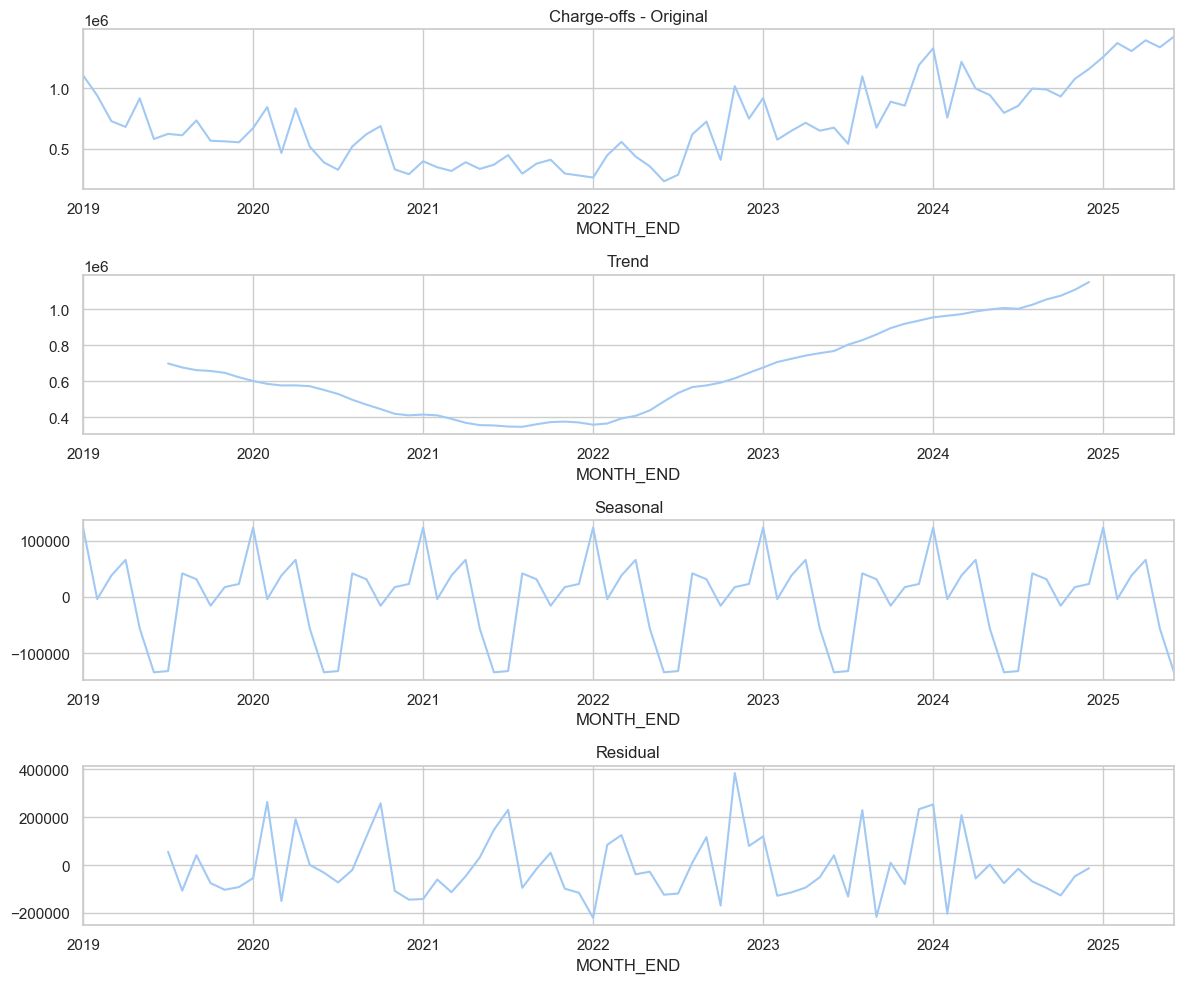

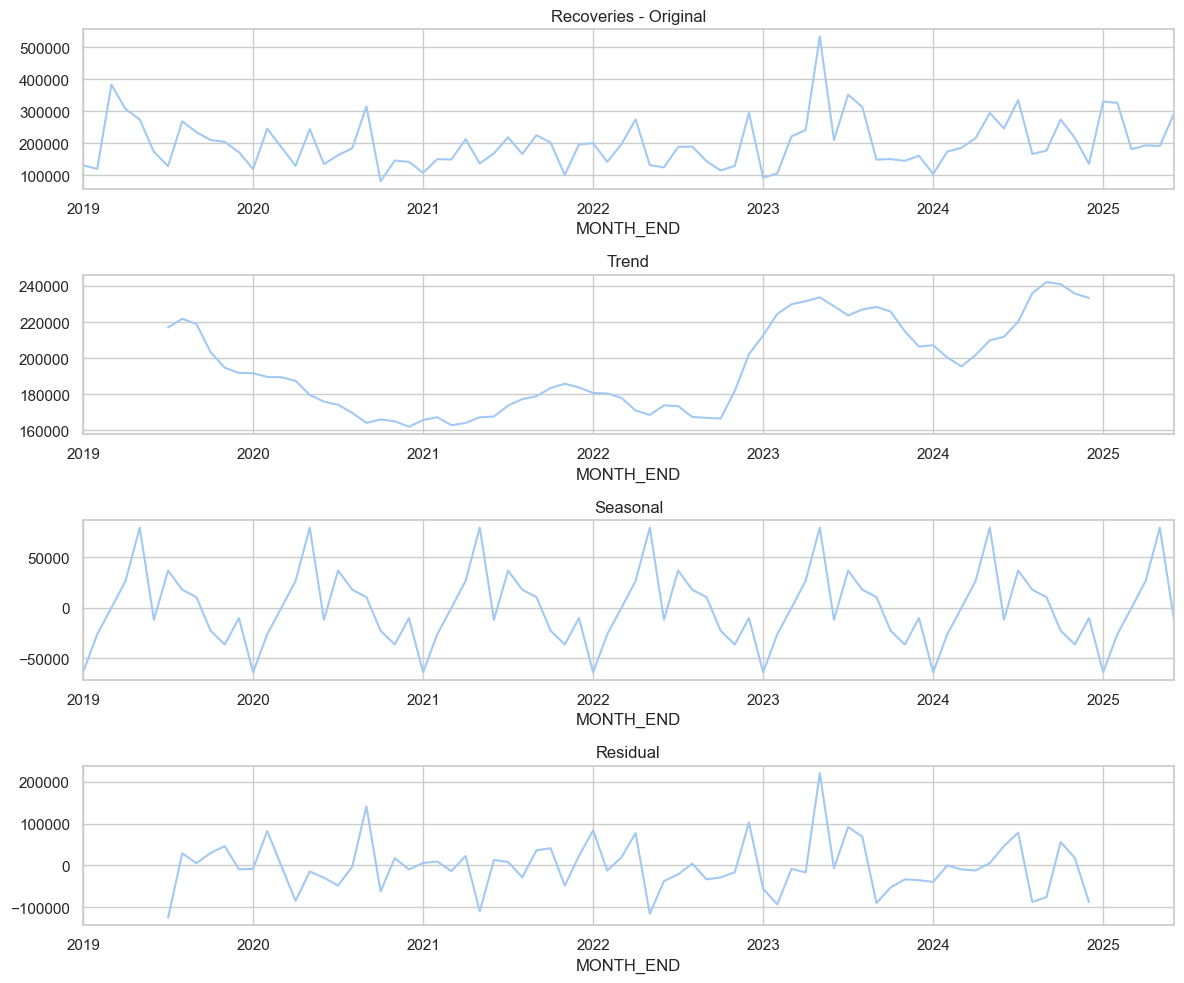

In [18]:
# Apply to your data
charge_decomp = analyze_seasonality(core_data['CO_BAL'], 'Charge-offs')
recovery_decomp = analyze_seasonality(core_data['REC_BAL'], 'Recoveries')

The seasonal decomposition reveals distinct patterns in both charge-offs and recoveries. For charge-offs, the trend component shows a clear U-shaped pattern with a decline from 2019 through mid-2021 (COVID), followed by steady growth from 2022 onward (Fed Funds Rate Increase), reaching approximately $1.1 million by 2025. The seasonal component demonstrates consistent annual cyclicality with regular peaks and troughs throughout each year, while the residual component shows significant volatility, particularly during 2020-2021 and 2023, indicating periods of unusual activity beyond normal seasonal patterns. 

Recovery data exhibits different characteristics with a more complex trend pattern that shows initial decline through 2021, followed by recovery and growth from 2022-2024, then stabilization around $240,000 by 2025. The seasonal component displays regular annual patterns similar to charge-offs but with smaller amplitude variations. The residuals show notable spikes, particularly in 2020 and 2023, suggesting external factors significantly impacted recovery performance during these periods.

The decomposition confirms that both series contain meaningful seasonal and trend components that can be modeled, with charge-offs showing stronger trending behavior (supporting the non-stationarity finding) while recoveries demonstrate more bounded variation around evolving trend levels (consistent with eventual mean reversion). The substantial residual components in both series indicate the presence of irregular shocks that pure trend and seasonal models may struggle to capture.

#### 1.4 Correlation Analysis & Outlier Detection

In [19]:
# Establish year for label
core_data['year'] = core_data.index.year
# Define colors for each year
years = sorted(core_data['year'].unique())
colors = plt.cm.RdYlBu(np.linspace(0, 1, len(years)))

In [20]:
co_outliers, co_lower_bound, co_upper_bound = detect_outliers(core_data['CO_BAL'])
rec_outliers, rec_lower_bound, rec_upper_bound = detect_outliers(core_data['REC_BAL'])
print("\033[1mOUTLIER DETECTION:\033[0m")
print(f"Charge-off outliers: {len(co_outliers)}")
print(f"Recovery outliers: {len(rec_outliers)}")

OUTLIER DETECTION:
Charge-off outliers: 0
Recovery outliers: 1


In [21]:
outlier_x = float(core_data['CO_BAL'][core_data['REC_BAL'] == max(core_data['REC_BAL'])])
outlier_y = max(core_data['REC_BAL'])

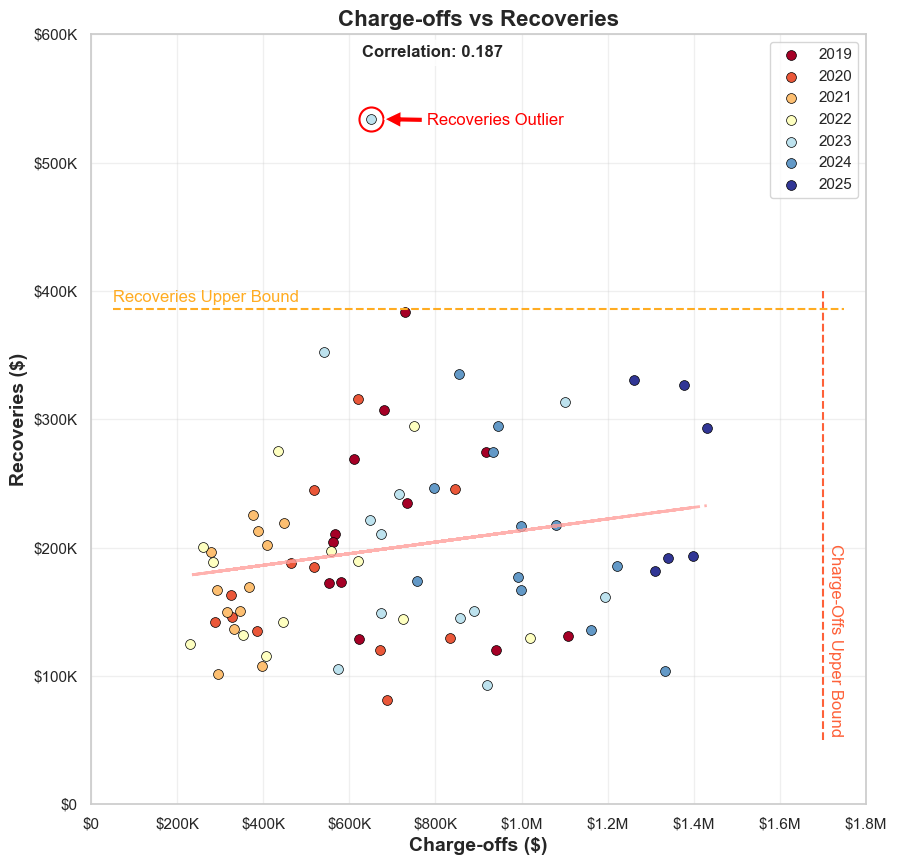

In [22]:
fig = plt.figure(figsize = (10, 10))


# Mark outlier
plt.scatter(outlier_x,
            outlier_y,
            facecolor= 'white',   # Color inside the marker
            edgecolors='red',    # Color of the outline
            linewidths=1.5,        # Width of the outline
            s=300,
            label='_Hidden') 
plt.annotate('Recoveries Outlier',  # Changed from 'axes fraction' to descriptive text
            xy=(outlier_x + 30000, outlier_y), xycoords='data',  # Point to annotate
            xytext=(outlier_x + 130000, outlier_y-6500), textcoords='data',  # Changed to data coordinates
            arrowprops=dict(facecolor='red', shrink=0.02),
            color='red', 
            horizontalalignment='left', verticalalignment='bottom')
# Color-code by time period to see if relationship changes
# Plot each year separately to create legend
for i, year in enumerate(years):
    year_data = core_data[core_data['year'] == year]
    plt.scatter(year_data['CO_BAL'], year_data['REC_BAL'], 
               c=colors[i], edgecolors= 'black', linewidths = 0.5,
               s=50, label=str(year))

#plt.colorbar(scatter, label='Time Period')
plt.legend(loc=0)
plt.xlabel('Charge-offs ($)', fontsize=14, fontweight='bold')
plt.xticks([0, 200000, 400000, 600000, 800000, 1000000,1200000,1400000, 1600000, 1800000], 
              ['$0', '$200K', '$400K', '$600K', '$800K', '$1.0M', '$1.2M', '$1.4M', '$1.6M', '$1.8M'])
plt.yticks([0, 100000, 200000, 300000, 400000, 500000, 600000], 
              ['$0', '$100K', '$200K', '$300K', '$400K', '$500K', '$600K'])
plt.ylabel('Recoveries ($)', fontsize=14, fontweight='bold')
plt.title('Charge-offs vs Recoveries', fontsize=16, fontweight='bold')

# Add trend line
z = np.polyfit(core_data['CO_BAL'], core_data['REC_BAL'], 1)
p = np.poly1d(z)
plt.plot(core_data['CO_BAL'], p(core_data['CO_BAL']), "r--", alpha=0.8, linewidth=2)

# Add upper and lower band for charge-offs
plt.plot([co_upper_bound, co_upper_bound], [50000, 400000], linestyle = "--", color =  "#fe6139") #upper bound
plt.plot([co_lower_bound, co_lower_bound], [50000, 400000], linestyle = "--", color =  "#fe6139") #lower bound is less than 0
plt.text(co_upper_bound + 10000, 55000, "Charge-Offs Upper Bound", rotation=-90,color="#fe6139")
# Add upper and lower band for recoveries
plt.plot([50000, 1750000], [rec_upper_bound, rec_upper_bound], linestyle = "--", color = "#ffac22") #upper bound
plt.plot([50000, 1750000], [rec_lower_bound, rec_lower_bound], linestyle = "--", color = "#ffac22") #lower bound is less than 0
plt.text(50000, rec_upper_bound + 6000, "Recoveries Upper Bound",color="#ffac22")


correlation = core_data['CO_BAL'].corr(core_data['REC_BAL'])
plt.text(0.35, 0.97, f'Correlation: {correlation:.3f}', 
         transform=plt.gca().transAxes, fontsize=12, fontweight= 'semibold',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.grid(True, alpha=0.3)
plt.xlim(0, 1800000)
plt.ylim(0, 600000)
plt.savefig("Outlier_detection.png")
plt.show()

The scatter plot reveals a weak positive correlation (0.187) between charge-offs and recoveries, indicating that higher charge-off periods are associated with slightly higher recovery amounts, though the relationship is not strong. The temporal clustering provides more insight than the correlation itself, showing distinct behavioral patterns across different economic periods.

The lower-left cluster dominated by 2020-2021 observations (red and orange points) reflects the pandemic period when regulatory forbearance and collection moratoriums significantly suppressed both charge-offs and recoveries. During this time, charge-offs remained artificially low due to extended delinquency periods (120-day extensions to 180+ days) while recovery efforts were constrained by regulatory restrictions and reduced collection activity.

In contrast, the upper-right portion shows increased density of 2024-2025 observations (dark blue points), indicating a return to normal collection practices combined with deteriorating credit conditions. This rightward shift suggests charge-offs have resumed normal patterns while moving to higher absolute levels, likely driven by macroeconomic pressures including elevated interest rates and inflationary impacts on borrower payment capacity.

The single recovery outlier at approximately $534K represents an exceptional collection event that falls well outside normal operational parameters. The overall pattern demonstrates how external economic and regulatory factors can create distinct regime shifts in the charge-off/recovery relationship, with implications for model stability across different market conditions.

In [23]:
print("\033[1mCORRELATION BY YEAR:\033[0m")
# Correlation by Year
for i in years:
    correlation = core_data['CO_BAL'][core_data['year'] == i].corr(core_data['REC_BAL'][core_data['year'] == i])
    print('{}: {}'.format(i, round(correlation, 3)))
    

CORRELATION BY YEAR:
2019: -0.162
2020: 0.135
2021: 0.425
2022: 0.09
2023: -0.238
2024: -0.613
2025: -0.059


The annual correlations show highly unstable relationships between charge-offs and recoveries, ranging from strongly negative (-0.613 in 2024) to moderately positive (0.425 in 2021). The 2021 peak correlation likely reflects synchronized pandemic recovery effects, while 2024's strong negative correlation suggests charge-offs increased substantially without corresponding recovery improvements.

## 2.0 Individual Series Analysis and Visualization

This section presents individual time series visualizations and comparative analysis to examine the temporal patterns, volatility, and relationships between charge-offs and recoveries across the 78-month observation period. The visualizations reveal distinct behavioral differences between the two series and highlight regime shifts corresponding to major economic events from 2019-2025.

#### 2.1 Historical Charge-Off Performance

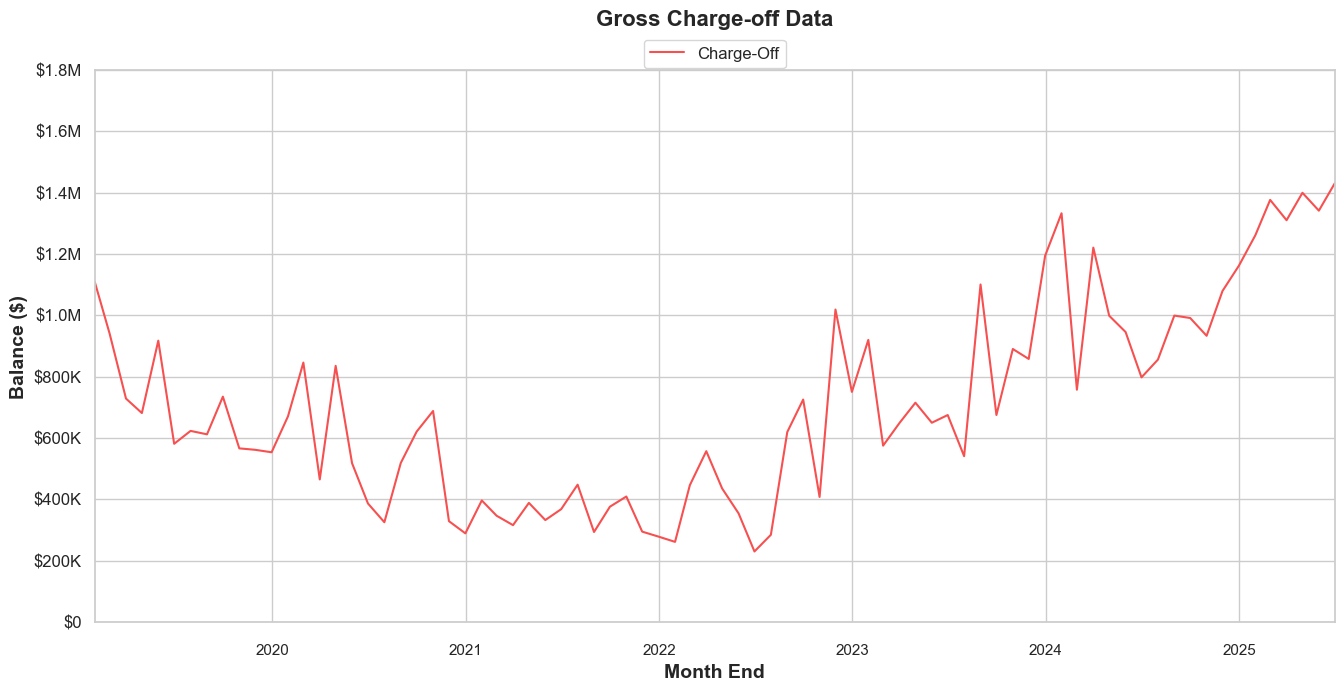

In [24]:
title = 'Gross Charge-off Data'
plot_data(title, core_data, 'CO', 'Charge-Off', 1,
              actual_data=True, trend_data = False, train_forecast=False, test_forecast=False, trend_train_forecast=False, trend_test_forecast=False, trend_ci=False)

Gross charge-offs declined significantly from 2019 through mid-2021, reaching a low of approximately $230K during the pandemic forbearance period. From 2022 onward, charge-offs have increased dramatically, rising from these historic lows to over $1.4M by 2025, representing more than a 500% increase from the trough levels.

#### 2.2 Historical Recoveries Performance

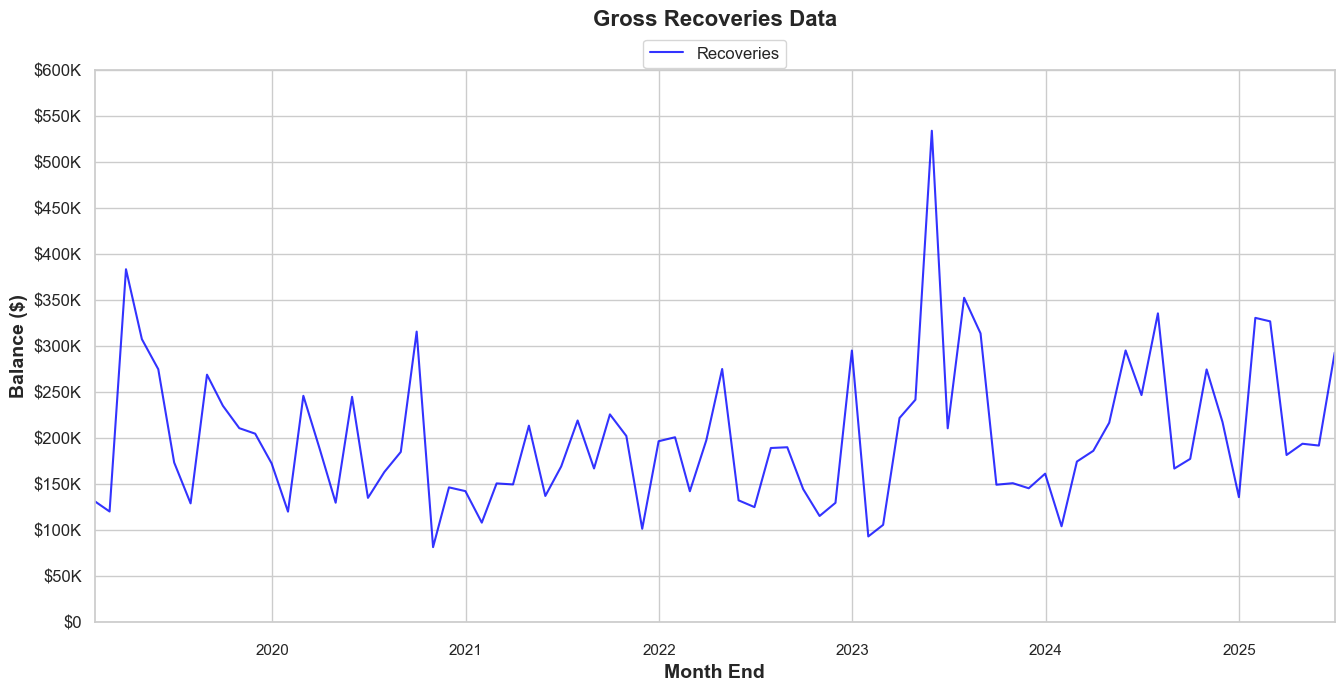

In [25]:
title = 'Gross Recoveries Data'
plot_data(title, core_data, 'REC', 'Recoveries', 1,
              actual_data=True, trend_data = False, train_forecast=False, test_forecast=False, trend_train_forecast=False, trend_test_forecast=False, trend_ci=False)

Recovery amounts show high volatility throughout the period, fluctuating between approximately $80K and $534K without a clear directional trend. The data shows "mean-reverting" behavior that hovers near $200K, with spikes in early 2019, mid-2020, and a significant peak exceeding $530K in 2023, followed by stabilization in the $200K-$330K range through 2025.

#### 2.3 Historical Charge-Off and Recoveries Combined Performance

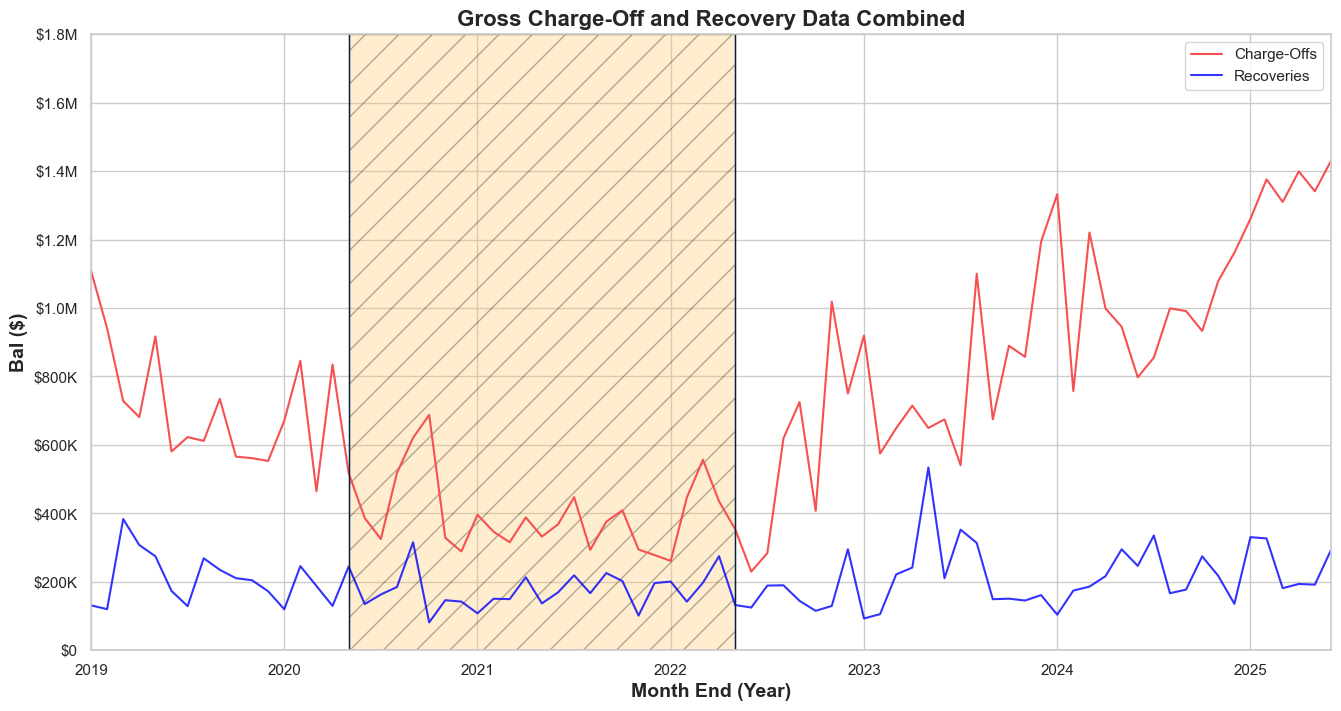

In [26]:
# Plot Charge-Off and Recovery Data Together
ax = core_data['CO_BAL'].plot(figsize=(16,8), color='#f75050', label= 'Charge-Offs')
ax = core_data['REC_BAL'].plot(figsize=(16,8), color='blue', alpha = 0.8, label= 'Recoveries')
ax.autoscale(axis='x', tight=True)
ax.set_ylabel('Bal ($)', size=14, fontweight='bold')
ax.set_xlabel('Month End (Year)', size=14, fontweight='bold')
ax.set_yticks([0, 200000, 400000, 600000, 800000, 1000000,1200000,1400000, 1600000, 1800000], 
              ['$0', '$200K', '$400K', '$600K', '$800K', '$1.0M', '$1.2M', '$1.4M', '$1.6M', '$1.8M'])

ax.axvspan('5/31/2020', '5/31/2022', alpha=0.3, hatch = "/", facecolor='#ffc561', edgecolor='black')
ax.vlines("5/31/2020", ymin=0, ymax=1800000, color= '#002147', lw=1)
ax.vlines("5/31/2022", ymin=0, ymax=1800000, color= '#002147', lw=1)

plt.legend(loc=0)
plt.ylim(0, 1800000)
plt.title('Gross Charge-Off and Recovery Data Combined', size=16, fontweight = 'bold')
plt.show();

The combined visualization shows the dramatic impact of COVID-era regulatory interventions on both charge-offs and recoveries from mid-2020 through mid-2022. The shaded period highlights when forbearance measures and softened colelction efforts artificially suppressed normal credit loss patterns, creating a distinct trough that contrasts sharply with pre-pandemic and recovery-phase behaviors.

COVID Period (Shaded Area):

- Charge-offs dropped to historic lows around $230K-$400K
- Recoveries remained relatively stable but constrained in the $100K-$250K range
- Both series show reduced volatility during regulatory intervention

Post-COVID Divergence:

- Charge-offs surge dramatically from 2022 onward, reaching $1.4M+ by 2025
- Recoveries return to pre-pandemic patterns, fluctuating around $200K-$300K with occasional spikes

#### 2.4 Ratio Visualization and Trend

In [27]:
stable = core_data.iloc[0:16]
covid = core_data.iloc[16:41]
rate_increase = core_data.iloc[42:]

In [28]:
stable = ratio_predictions(stable)
covid = ratio_predictions(covid)
rate_increase = ratio_predictions(rate_increase)


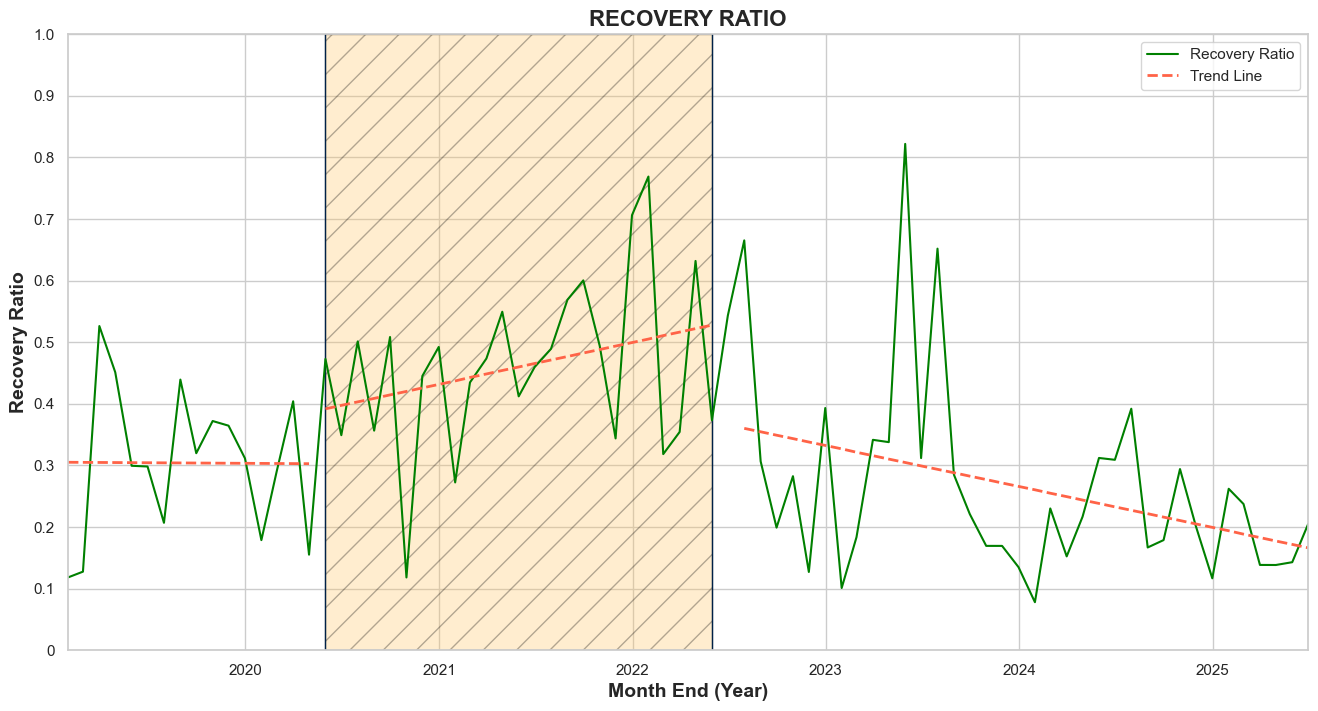

In [29]:
# Plot Charge-Off and Recovery Data Together
fig, ax = plt.subplots(figsize=(16,8))  # Changed this line

# Convert string dates to datetime objects
start_date = pd.to_datetime('2020-05-31')
end_date = pd.to_datetime('2022-05-31')

ax.axvspan(start_date, end_date, hatch = "/", facecolor="#ffc561", alpha=0.3, edgecolor='black')
ax.vlines(start_date, ymin=0, ymax=1800000, color= '#002147', lw=1)
ax.vlines(end_date, ymin=0, ymax=1800000, color= '#002147', lw=1)

ax.plot(core_data.index, core_data['ratio'], color='green', label='Recovery Ratio')
ax.autoscale(axis='x', tight=True)
ax.set_ylabel('Recovery Ratio', size=14, fontweight='bold')
ax.set_xlabel('Month End (Year)', size=14, fontweight='bold')
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
              ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0'])

ax.plot(stable.index, stable['Predictions'], "r--", color='tomato', linewidth=2, label= 'Trend Line')
ax.plot(covid.index, covid['Predictions'], "r--", color='tomato', linewidth=2, label='_Hidden')
ax.plot(rate_increase.index, rate_increase['Predictions'], "r--", color='tomato', linewidth=2,label='_Hidden')

plt.legend(loc=0)
plt.ylim(0, 1)
plt.title('RECOVERY RATIO', size=16, fontweight = 'bold')
plt.show();

The recovery ratio analysis reveals three distinct operational regimes with dramatically different collection effectiveness patterns. During the pre-pandemic period, ratios remained relatively stable around 30%, reflecting normal collection operations. The COVID moratorium period shows initial volatility followed by improving ratios that peaked near 80% as charge-offs were artificially suppressed while some recovery activities continued. The post-2022 period demonstrates a sharp deterioration in collection effectiveness, with ratios declining to 15-20% as charge-offs surged while recovery amounts failed to scale proportionally.

Key Insights:

- Pre-COVID Baseline (2019-2020): Recovery ratios maintained steady 30% average with moderate volatility, indicating normal collection operations
- COVID Peak Distortion (2020-2022): Ratios artificially inflated to 50-80% due to regulatory forbearance suppressing charge-offs while maintaining some collection activity
- Post-Pandemic Deterioration (2022-2025): Sharp decline in collection effectiveness to 15-20% as charge-offs resumed aggressive growth without proportional recovery scaling
- Regime Instability: The dramatic shifts across periods indicate that any modeling assumption of stable recovery relationships will likely fail across different market conditions
- Collection Capacity Constraints: The declining trend post-2022 suggests collection operations may be overwhelmed by the surge in charge-off volumes

## 3.0 Visualize the Charge-Off Trend

#### 3.1 Generate Charge-Off Exponential Trend Line

In [30]:
core_trend_data = hpfilter_trend_cycling(core_data, 'CO_BAL', 1000)

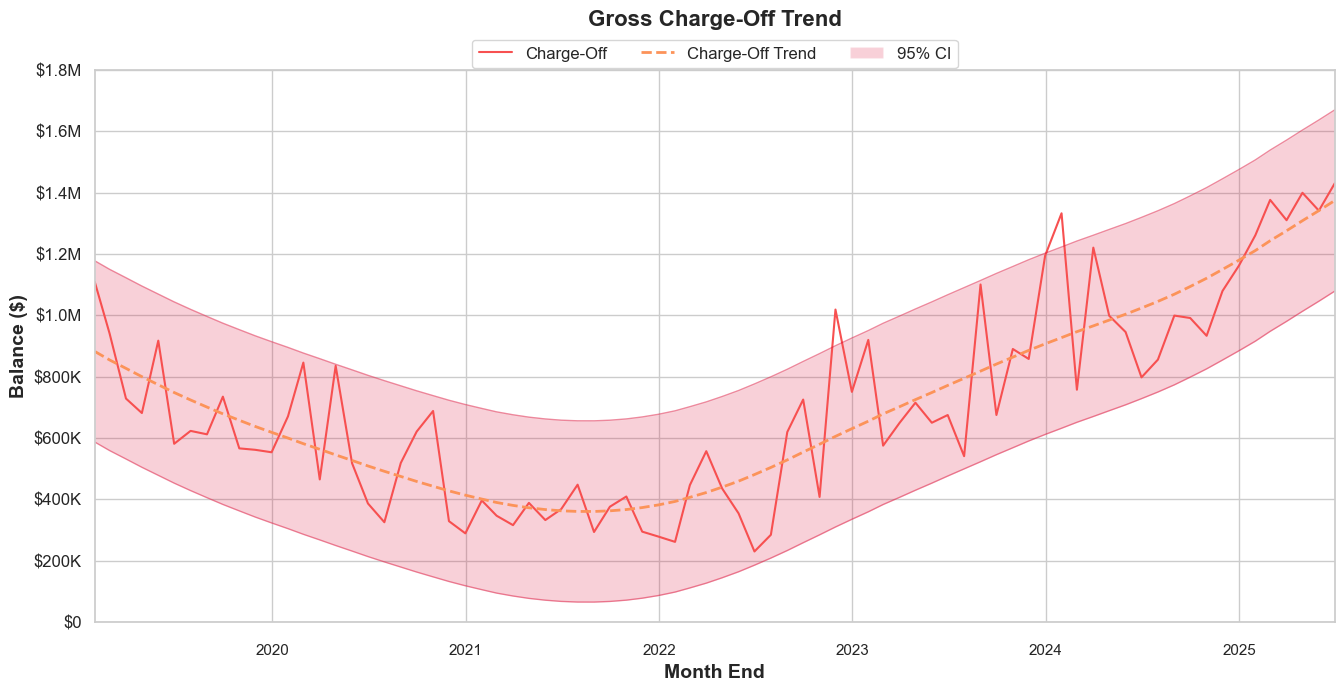

In [31]:
title = 'Gross Charge-Off Trend'
plot_data(title, core_trend_data, 'CO', 'Charge-Off', 3,
              actual_data=True, trend_data=True, train_forecast=False, test_forecast=False, trend_train_forecast=False, trend_test_forecast=False, trend_ci=True)

#### 3.2 Generate Charge-Off Exponential Trend Line

In [32]:
core_trend_data, rec_cycle, rec_trend = hpfilter_trend_cycling(core_data, 'REC_BAL', 129600, return_cycle_trend=True)

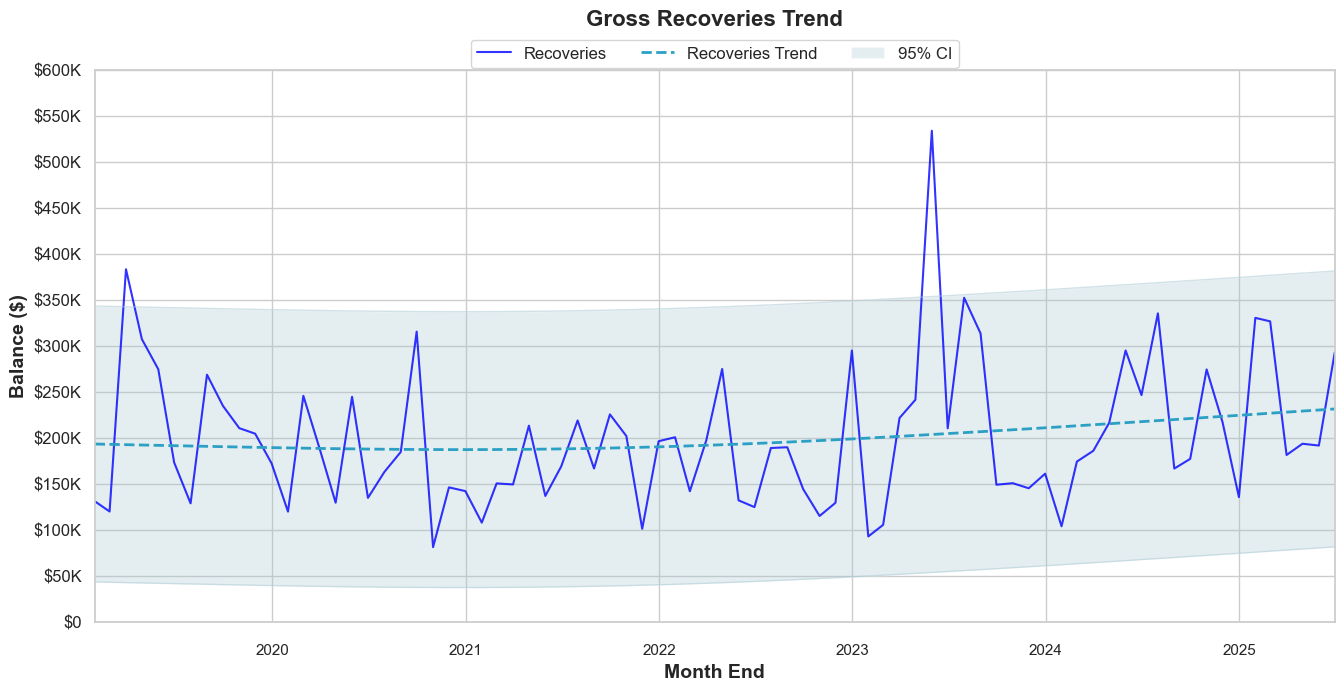

In [33]:
title = 'Gross Recoveries Trend'
plot_data(title, core_trend_data, 'REC', 'Recoveries', 3,
              actual_data=True, trend_data=True, train_forecast=False, test_forecast=False, trend_train_forecast=False, trend_test_forecast=False, trend_ci=True)

#### 3.3 Combined Charge-offs and Recoveries

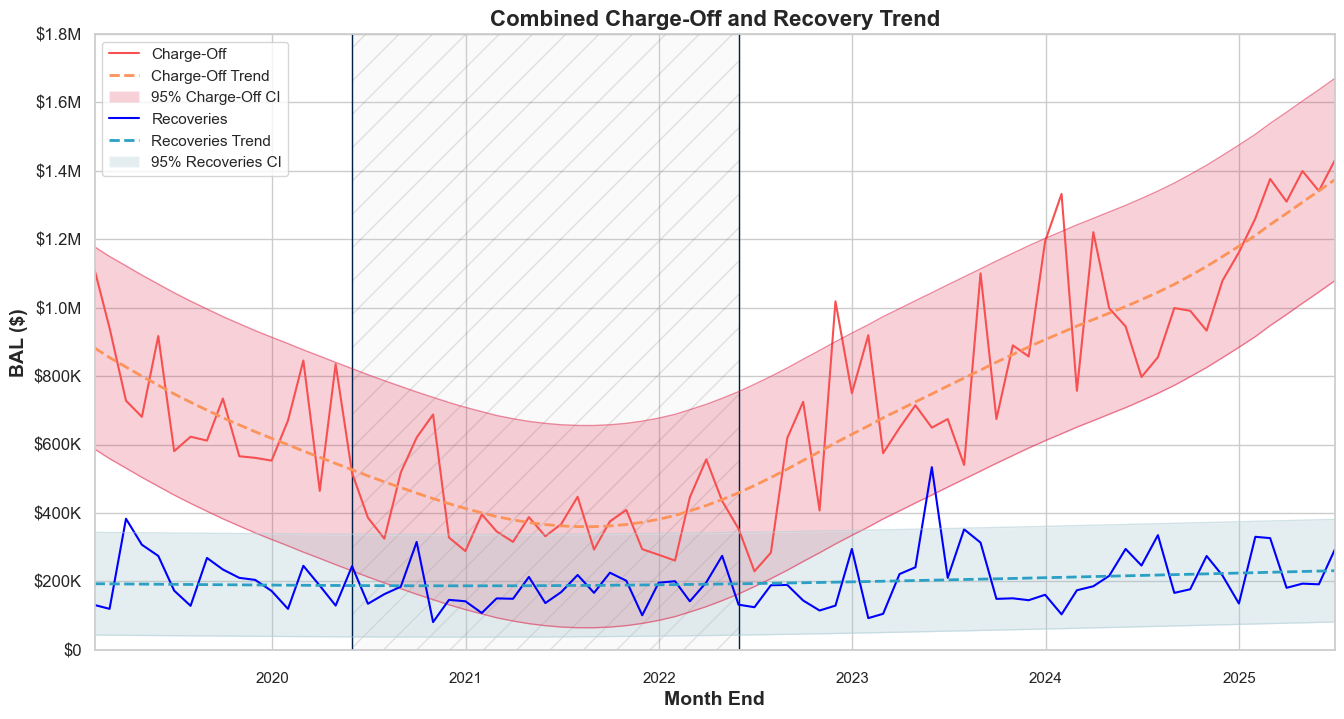

In [34]:
# Combined chart

# Plot Charge-Off and Recovery Data Together
fig, ax = plt.subplots(figsize=(16,8))  # Changed this line

# Convert string dates to datetime objects
start_date = pd.to_datetime('2020-05-31')
end_date = pd.to_datetime('2022-05-31')

ax.axvspan(start_date, end_date, alpha=0.1, hatch = "/", facecolor="lightgrey", edgecolor='black')
ax.vlines(start_date, ymin=0, ymax=1800000, color= '#002147', lw=1)
ax.vlines(end_date, ymin=0, ymax=1800000, color= '#002147', lw=1)

# Plot CO data
ax.plot(core_trend_data.index, core_trend_data['CO_BAL'], color='#f75050', label='Charge-Off')
ax.plot(core_trend_data.index, core_trend_data['CO_BAL_trend'], color='#fc9359', linestyle="--", lw=2, label='Charge-Off Trend')
ax.plot(core_trend_data.index, core_trend_data['CO_BAL_trend_upper'], color='crimson', alpha=0.5, lw=1, label='_Hidden')
ax.plot(core_trend_data.index, core_trend_data['CO_BAL_trend_lower'], color='crimson', alpha=0.5, lw=1, label='_Hidden')
ax.fill_between(core_trend_data.index.values, core_trend_data['CO_BAL_trend_lower'], core_trend_data['CO_BAL_trend_upper'], 
                facecolor='crimson', alpha=0.2, label='95% Charge-Off CI')

# Plot Recovery Data
ax.plot(core_trend_data.index, core_trend_data['REC_BAL'], color='blue', label='Recoveries')
ax.plot(core_trend_data.index, core_trend_data['REC_BAL_trend'], color="#2ba0c4", linestyle="--", lw=2, label='Recoveries Trend')
ax.plot(core_trend_data.index, core_trend_data['REC_BAL_trend_upper'], color='#a7c8d2', alpha=0.5, lw=1, label='_Hidden')
ax.plot(core_trend_data.index, core_trend_data['REC_BAL_trend_lower'], color='#a7c8d2', alpha=0.5, lw=1, label='_Hidden')
ax.fill_between(core_trend_data.index.values, core_trend_data['REC_BAL_trend_lower'], core_trend_data['REC_BAL_trend_upper'], 
                facecolor='#a7c8d2', alpha=0.3, label='95% Recoveries CI')

ax.autoscale(axis='x',tight=True)
ax.set_ylabel('BAL ($)', fontsize=14, fontweight='bold')
ax.set_xlabel('Month End', fontsize=14, fontweight='bold')
ax.set_yticks([0, 200000, 400000, 600000, 800000, 1000000,1200000,1400000, 1600000, 1800000], 
              ['$0', '$200K', '$400K', '$600K', '$800K', '$1.0M', '$1.2M', '$1.4M', '$1.6M', '$1.8M'],
              fontsize=12)
ax.tick_params(axis='x', size=12)
plt.legend(loc=0)
plt.ylim(0, 1800000)
plt.title('Combined Charge-Off and Recovery Trend', size=16, fontweight='bold')
plt.show();

## 4.0 Forecast Balances with Holtwinters Exponential Smoothing

Introductory writeup

#### 4.1a Fitting Model for Forecasting Charge-Offs

In [35]:
co_train_data, co_test_data = split_data(core_trend_data, 'CO_BAL', 12)
core_forecast_data, co_train_fitted_model, mae, rmse, mse, mape, r2 = fit_model(co_train_data,'mul', 'mul', True, True, core_trend_data, core_trend_data, 'CO_BAL_train_forecast')
print("")
print_output_fit_model(mae, mse, rmse, mape, r2)

Train period: 2019-01-31 00:00:00 to 2024-06-30 00:00:00
Test period: 2024-07-31 00:00:00 to 2025-06-30 00:00:00
Train size: 66 months
Test size: 12 months

In-Sample Performance:
MAE: $119,345
MSE: $22,481,527,685
RMSE: $149,938
MAPE: 21.61%
R-squared: 0.676


In [36]:
core_forecast_data.columns

Index(['CO_BAL', 'REC_BAL', 'ratio', 'year', 'CO_BAL_trend',
       'CO_BAL_trend_upper', 'CO_BAL_trend_lower', 'REC_BAL_trend',
       'REC_BAL_trend_upper', 'REC_BAL_trend_lower', 'CO_BAL_train_forecast'],
      dtype='object')

Comment on this is an initial run of our model. We need to generate a for loop to determine the best model type

In [37]:
hyperparameter_tuning(co_train_data)

HYPERPARAMETERS: Trend: None | Seasonal: add | Damped: False || RESULTS: Ratio: 1.00 | R-squared: 0.60 | MAPE: 24.16%
HYPERPARAMETERS: Trend: add | Seasonal: add | Damped: False || RESULTS: Ratio: 1.00 | R-squared: 0.60 | MAPE: 22.93%
HYPERPARAMETERS: Trend: add | Seasonal: add | Damped: True || RESULTS: Ratio: 1.00 | R-squared: 0.64 | MAPE: 22.99%
HYPERPARAMETERS: Trend: add | Seasonal: None | Damped: False || RESULTS: Ratio: 1.00 | R-squared: 0.52 | MAPE: 24.72%
HYPERPARAMETERS: Trend: None | Seasonal: None | Damped: False || RESULTS: Ratio: 1.00 | R-squared: 0.51 | MAPE: 25.24%
HYPERPARAMETERS: Trend: mul | Seasonal: mul | Damped: False || RESULTS: Ratio: 1.00 | R-squared: 0.67 | MAPE: 21.35%
HYPERPARAMETERS: Trend: mul | Seasonal: mul | Damped: True || RESULTS: Ratio: 1.00 | R-squared: 0.68 | MAPE: 21.61%


Go with mul, mul, damped=False

#### 4.1b Forecasting Fitted Values on Training Data

In [38]:
co_train_data, co_test_data = split_data(core_forecast_data, 'CO_BAL', 12)
core_forecast_data, co_train_fitted_model, mae, rmse, mse, mape, r2 = fit_model(co_train_data,'mul', 'mul', False, True, core_trend_data, core_trend_data, 'CO_BAL_train_forecast')
print("")
print_output_fit_model(mae, mse, rmse, mape, r2)

Train period: 2019-01-31 00:00:00 to 2024-06-30 00:00:00
Test period: 2024-07-31 00:00:00 to 2025-06-30 00:00:00
Train size: 66 months
Test size: 12 months

In-Sample Performance:
MAE: $118,693
MSE: $22,710,045,606
RMSE: $150,699
MAPE: 21.35%
R-squared: 0.672


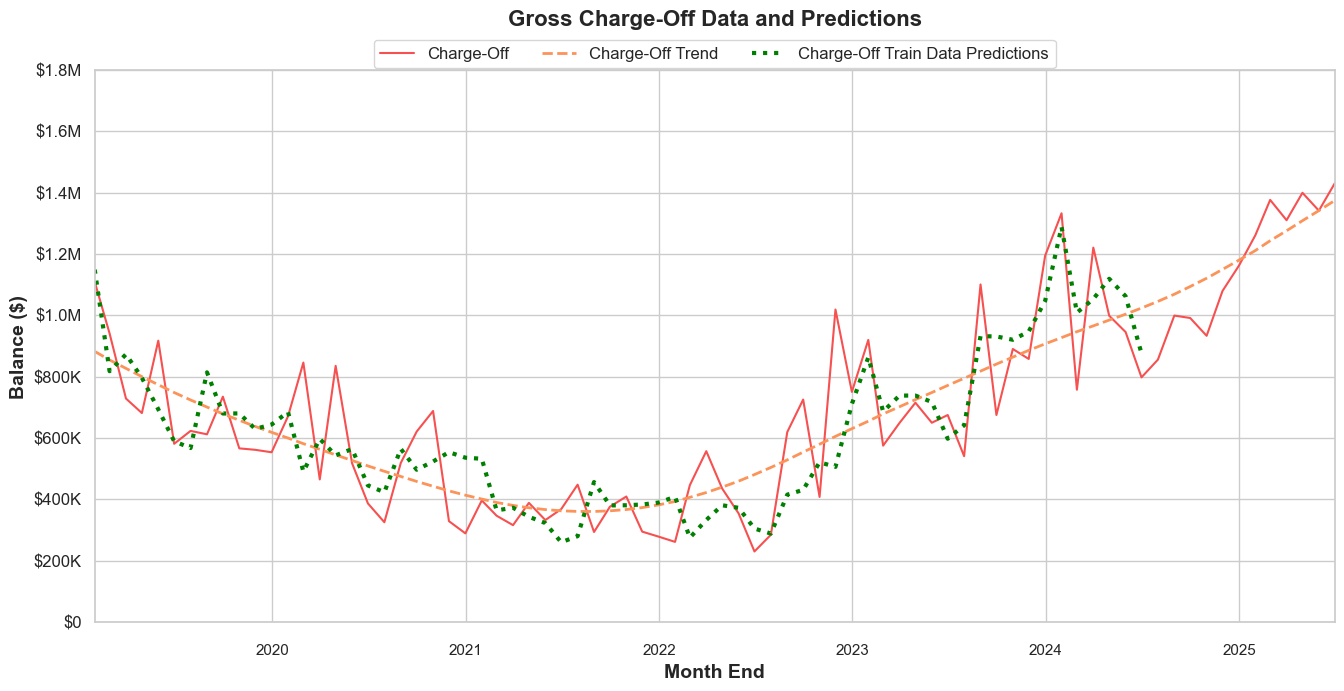

In [39]:
title = 'Gross Charge-Off Data and Predictions'
plot_data(title, core_forecast_data, 'CO', 'Charge-Off', 3,
              actual_data=True, trend_data=True, train_forecast=True, test_forecast=False, trend_train_forecast=False, trend_test_forecast=False, trend_ci=False)

In [40]:
average_train_data = co_train_data.mean()
std_train_data = co_train_data.std()

average_train_forecast_data = core_forecast_data[core_forecast_data.notna()]['CO_BAL_train_forecast'].mean()
std_train_forecast_data = core_forecast_data[core_forecast_data.notna()]['CO_BAL_train_forecast'].std()

print("Mean Training Data: ${:,.2f}".format(average_train_data))
print("Std Dev of Training Data: ${:,.2f}".format(std_train_data))
print("Mean Fitted Values: ${:,.2f}".format(average_train_forecast_data))
print("Std Dev Fitted Values: ${:,.2f}".format(std_train_forecast_data))

Mean Training Data: $619,944.14
Std Dev of Training Data: $265,320.10
Mean Fitted Values: $619,944.14
Std Dev Fitted Values: $249,862.20


While not perfect - it doesn't appear to catch all the up and down movements. However, it does appear to follow the dip and rise of the general trend. Comment on the metrics below as proof.

#### 4.2a Test Charge-Off Model

In [41]:
core_forecast_data = forecast_data(co_train_fitted_model, core_forecast_data, co_test_data, 'CO', trend=False)

Actual mean: $1,178,043
Stable forecast mean: $1,382,133
Ratio: 1.17x
MAPE: 20.69%
R²: -1.032


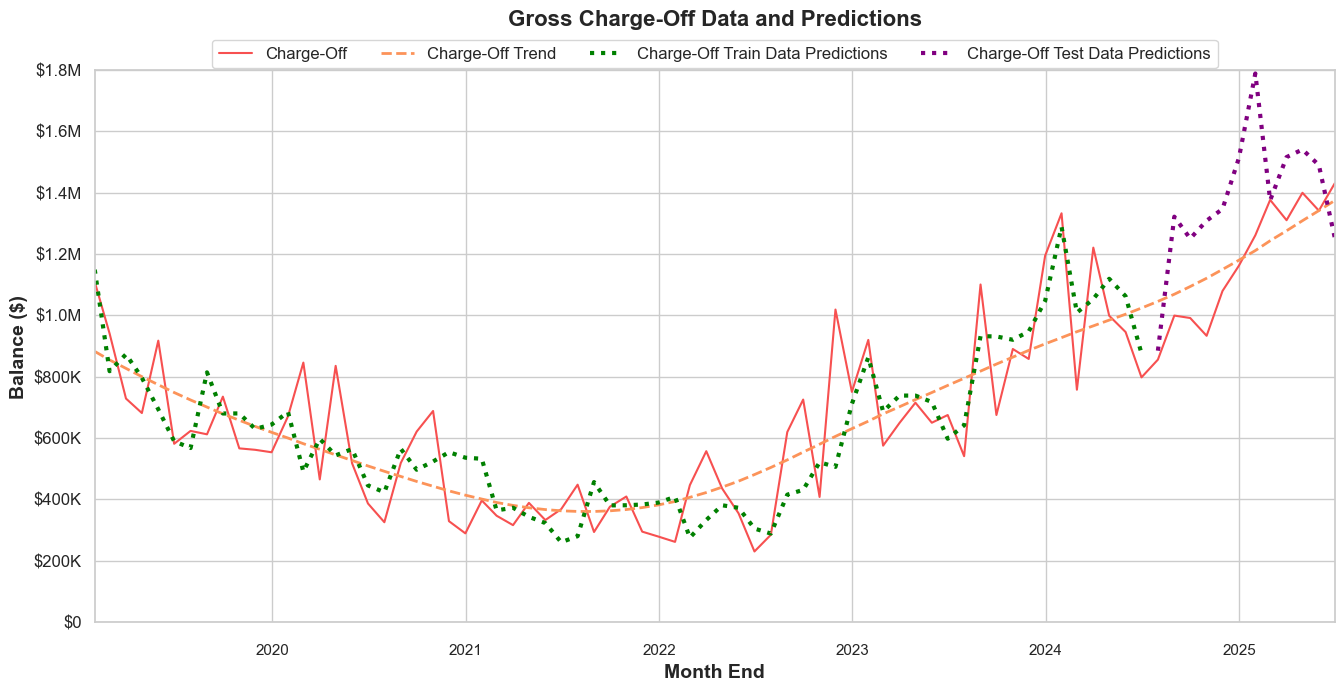

In [42]:
title = 'Gross Charge-Off Data and Predictions'
plot_data(title, core_forecast_data, 'CO', 'Charge-Off', 4,
              actual_data=True, trend_data=True, train_forecast=True, test_forecast=True, trend_train_forecast=False, trend_test_forecast=False, trend_ci=False)

Correct in predicting the general trend, however it is over correcting for the spikes. Hence the negtive r2. That is also why the actual mean is lower than the forecast mean.

In [43]:
core_forecast_data.columns

Index(['CO_BAL', 'REC_BAL', 'ratio', 'year', 'CO_BAL_trend',
       'CO_BAL_trend_upper', 'CO_BAL_trend_lower', 'REC_BAL_trend',
       'REC_BAL_trend_upper', 'REC_BAL_trend_lower', 'CO_BAL_train_forecast',
       'CO_BAL_test_forecast'],
      dtype='object')

#### 4.2b Let's test how far this bounces outside of confidence interval

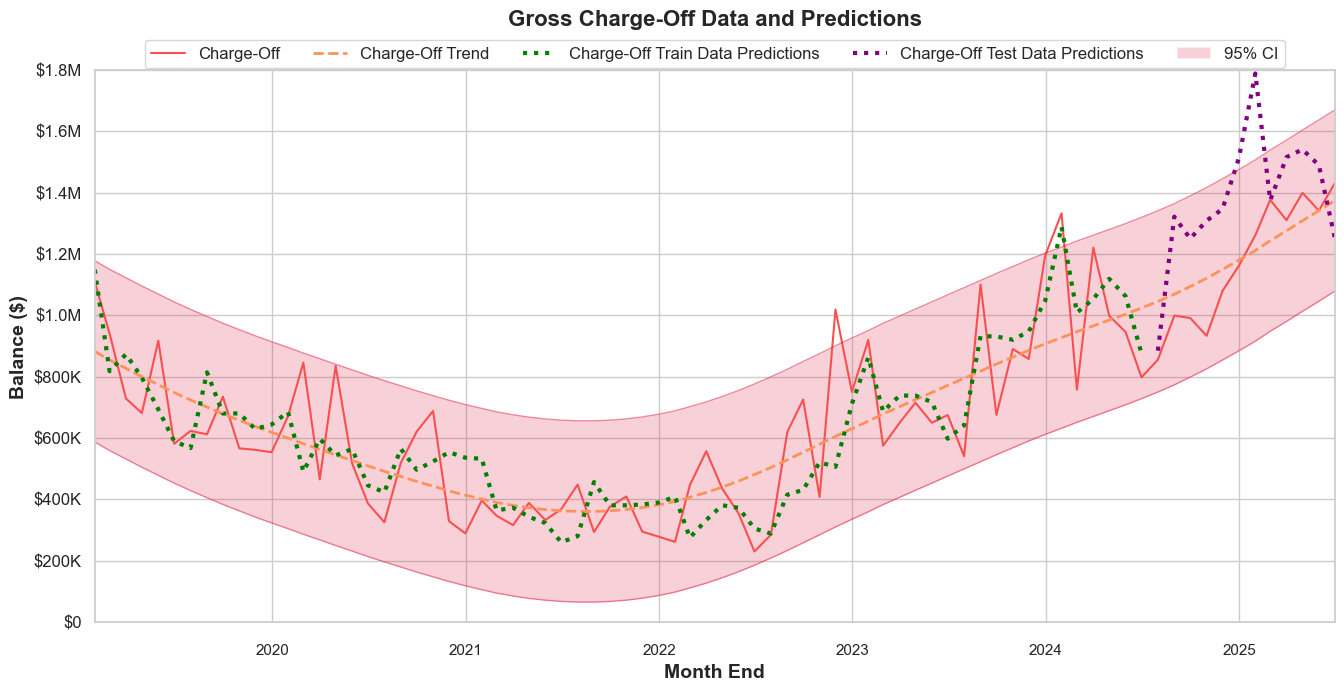

In [44]:
title = 'Gross Charge-Off Data and Predictions'
plot_data(title, core_forecast_data, 'CO', 'Charge-Off', 5,
              actual_data=True, trend_data=True, train_forecast=True, test_forecast=True, trend_train_forecast=False, trend_test_forecast=False, trend_ci=True)

Really just the one spike. And if we combine the data, we have two spikes that are outliers. that is 2/78 or less than 5%. So lower than our degree of confidence and within range.

#### 4.3a Run this model build on our trend data

Explain that while predicting charge-offs is fun, and the genreal trend appears correct, we should focus ont he actual trended data and predict intervals off of that. So, we're going to pivot and leverage our HP Filter trends for testing. 

#### 4.3b Train on HP Filter trend

In [45]:
co_trend_train_data, co_trend_test_data = split_data(core_forecast_data, 'CO_BAL_trend', 12)
core_forecast_data, co_trend_train_fitted_model, mae, rmse, mse, mape, r2 = fit_model(co_trend_train_data,'mul', 'mul', False, True, core_forecast_data, core_forecast_data, 'CO_BAL_trend_train_forecast')
print("")
print_output_fit_model(mae, mse, rmse, mape, r2)

Train period: 2019-01-31 00:00:00 to 2024-06-30 00:00:00
Test period: 2024-07-31 00:00:00 to 2025-06-30 00:00:00
Train size: 66 months
Test size: 12 months

In-Sample Performance:
MAE: $911
MSE: $1,195,066
RMSE: $1,093
MAPE: 0.18%
R-squared: 1.000


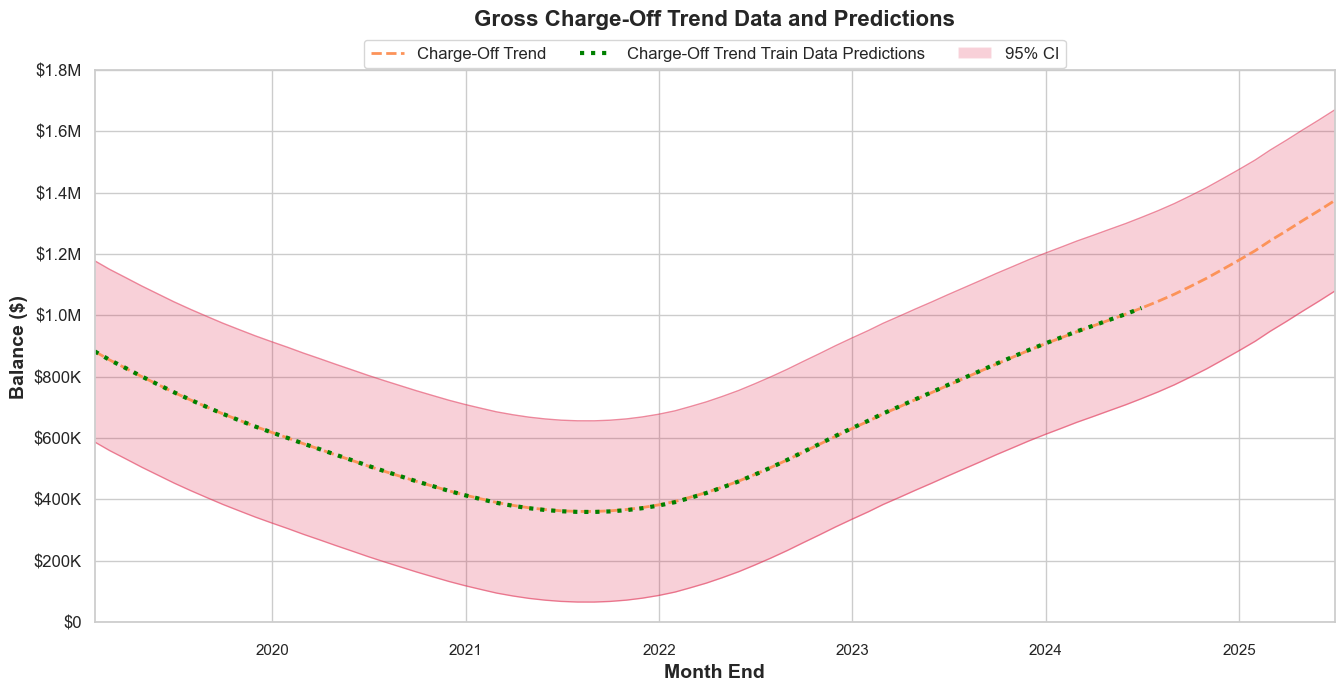

In [46]:
title = 'Gross Charge-Off Trend Data and Predictions'
plot_data(title, core_forecast_data, 'CO', 'Charge-Off', 3,
              actual_data=False, trend_data=True, train_forecast=False, test_forecast=False, trend_train_forecast=True, trend_test_forecast=False, trend_ci=True)

Comments - No need to test. Appears to be perfectly aligned.

In [47]:
core_forecast_data.columns

Index(['CO_BAL', 'REC_BAL', 'ratio', 'year', 'CO_BAL_trend',
       'CO_BAL_trend_upper', 'CO_BAL_trend_lower', 'REC_BAL_trend',
       'REC_BAL_trend_upper', 'REC_BAL_trend_lower', 'CO_BAL_train_forecast',
       'CO_BAL_test_forecast', 'CO_BAL_trend_train_forecast'],
      dtype='object')

#### 4.4a Forecasting on Full Dataset

In [48]:
co_full_data = core_forecast_data['CO_BAL']

In [49]:
core_forecast_data, CO_BAL_forecast_model, mae, rmse, mse, mape, r2 = fit_model(co_full_data,'mul', 'mul', True, True, core_forecast_data, core_forecast_data, 'CO_BAL_train_forecast')
print("")
print_output_fit_model(mae, mse, rmse, mape, r2)


In-Sample Performance:
MAE: $119,808
MSE: $22,738,558,969
RMSE: $150,793
MAPE: 20.02%
R-squared: 0.783


In [50]:
# Forecast 12 months into the future
forecast_periods = 12
future_forecast = CO_BAL_forecast_model.forecast(forecast_periods)

In [51]:
future_dates = future_forecast.index

# Create extended index
extended_index = core_forecast_data.index.append(future_dates)

# Reindex the DataFrame (adds NaN for new rows)
core_forecast_data = core_forecast_data.reindex(extended_index)

core_forecast_data['CO_BAL_future_forecast'] = future_forecast

In [52]:
# Utilize residuals to generate a confidence interval
test_residuals = co_test_data - core_forecast_data['CO_BAL_test_forecast']
residual_std = np.std(test_residuals)

print(f"Test set residual standard deviation: ${residual_std:,.0f}")

Test set residual standard deviation: $183,034


In [53]:
# Generate confidence intervals for 12-month forecast
forecast_periods = len(future_forecast)
z_score = 1.96  # 95% confidence level

# Create expanding uncertainty (gets wider over time)
# Use slower expansion - square root of months may be too aggressive
time_expansion = np.arange(1, forecast_periods + 1) * 0.1  # Linear with smaller factor
forecast_std_errors = residual_std * time_expansion

# Calculate bounds
forecast_lower = future_forecast - (z_score * forecast_std_errors)
forecast_upper = future_forecast + (z_score * forecast_std_errors)

In [54]:
core_forecast_data['CO_BAL_future_forecast_lower_bound'] = forecast_lower
core_forecast_data['CO_BAL_future_forecast_upper_bound'] = forecast_upper

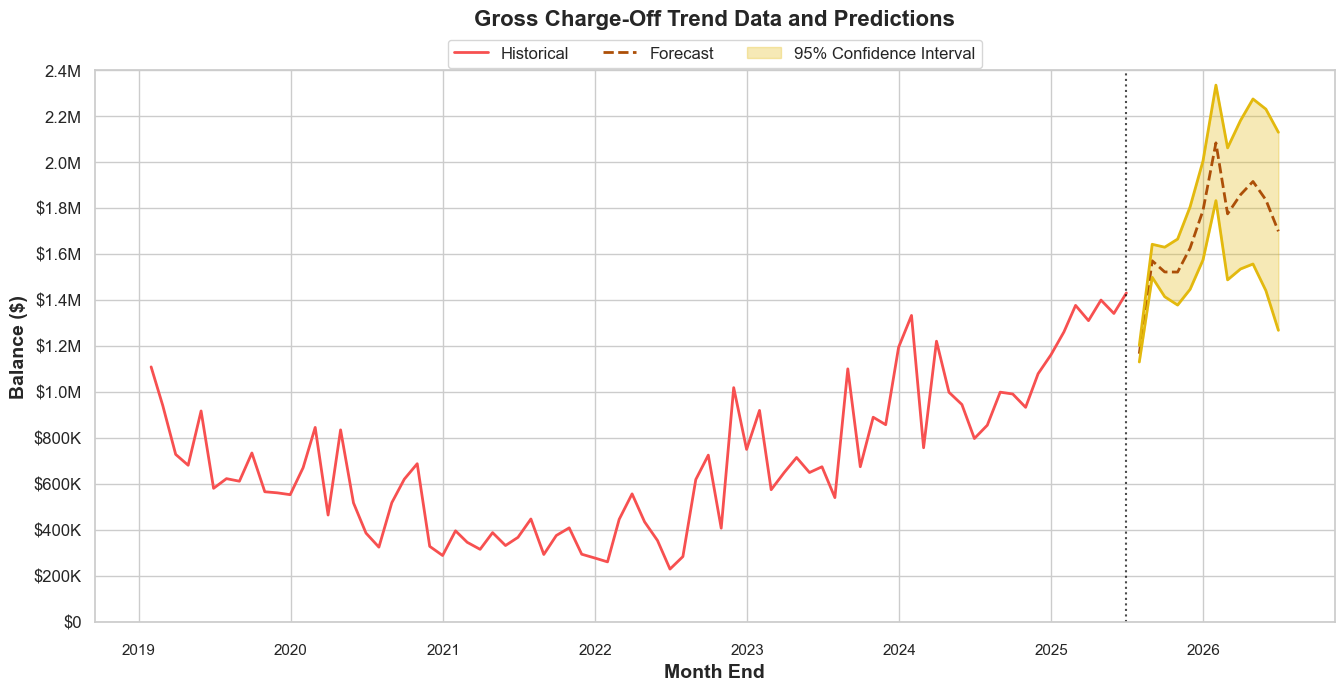

In [55]:
# Plot Charge-Off and Recovery Data Together
fig, ax = plt.subplots(figsize=(16,8))  # Changed this line

plt.title(title, size=16, fontweight='bold', pad=32)  # Add pad for spacing
# Historical data
ax.plot(core_forecast_data.index, core_forecast_data['CO_BAL'], color = '#f75050', label='Historical', linewidth=2)

# Future forecasts
ax.plot(core_forecast_data.index, core_forecast_data['CO_BAL_future_forecast'], color = "#ac4f08", linestyle='--', label='Forecast', linewidth=2)
ax.plot(core_forecast_data.index, core_forecast_data['CO_BAL_future_forecast_lower_bound'], color = "#e3b90e", linewidth=2)
ax.plot(core_forecast_data.index, core_forecast_data['CO_BAL_future_forecast_upper_bound'], color = "#e3b90e", linewidth=2)

ax.fill_between(future_dates, 
                np.array(forecast_lower), 
                np.array(forecast_upper), 
                alpha=0.3, color="#e3b90e", label='95% Confidence Interval')

# Add vertical line at forecast start
ax.axvline(x=core_forecast_data['CO_BAL_future_forecast'].index[-13], color='black', linestyle=':', alpha=0.7)

#ax.autoscale(axis='x',tight=True)
ax.set_ylabel('Balance ($)', fontsize=14, fontweight='bold')
ax.set_xlabel('Month End', fontsize=14, fontweight='bold')

yticks = [0, 200000, 400000, 600000, 800000, 1000000,1200000,1400000, 1600000, 1800000, 2000000, 2200000, 2400000]
yticks_labels = ['$0', '$200K', '$400K', '$600K', '$800K', '$1.0M', '$1.2M', '$1.4M', '$1.6M', '$1.8M', '2.0M', '2.2M', '2.4M']
ax.set_yticks(yticks, yticks_labels, fontsize=12)
ax.tick_params(axis='x', size=12)

# Position legend between title and plot
plt.legend(bbox_to_anchor=(0.5, 1.07), loc='upper center', ncol=4, fontsize=12)
plt.subplots_adjust(top=0.80)  # Make more room at the top
plt.ylim(0, max(yticks))
plt.show();

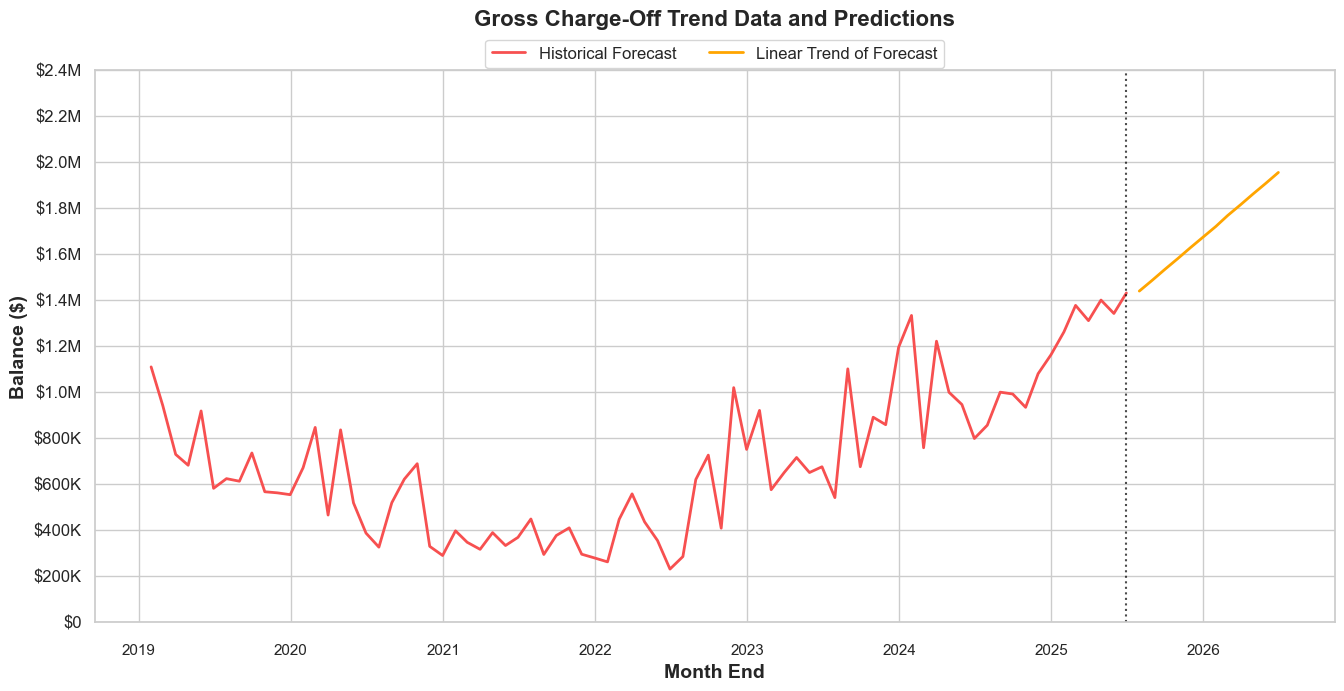

In [56]:
# Plot Charge-Off and Recovery Data Together
fig, ax = plt.subplots(figsize=(16,8))  # Changed this line

plt.title(title, size=16, fontweight='bold', pad=32)  # Add pad for spacing
# Historical data
ax.plot(core_forecast_data.index, core_forecast_data['CO_BAL'], color = '#f75050', label='Historical Forecast', linewidth=2)

# Fit linear trend to forecast
X = np.arange(len(future_forecast)).reshape(-1, 1)
reg = LinearRegression().fit(X, future_forecast)
forecast_trend = reg.predict(X)

ax.plot(future_dates, forecast_trend, 'orange', linewidth=2, label='Linear Trend of Forecast')

# Add vertical line at forecast start
ax.axvline(x=core_forecast_data['CO_BAL_future_forecast'].index[-13], color='black', linestyle=':', alpha=0.7)

#ax.autoscale(axis='x',tight=True)
ax.set_ylabel('Balance ($)', fontsize=14, fontweight='bold')
ax.set_xlabel('Month End', fontsize=14, fontweight='bold')

yticks = [0, 200000, 400000, 600000, 800000, 1000000,1200000,1400000, 1600000, 1800000, 2000000, 2200000, 2400000]
yticks_labels = ['$0', '$200K', '$400K', '$600K', '$800K', '$1.0M', '$1.2M', '$1.4M', '$1.6M', '$1.8M', '$2.0M', '$2.2M', '$2.4M']
ax.set_yticks(yticks, yticks_labels, fontsize=12)
ax.tick_params(axis='x', size=12)

# Position legend between title and plot
plt.legend(bbox_to_anchor=(0.5, 1.07), loc='upper center', ncol=4, fontsize=12)
plt.subplots_adjust(top=0.80)  # Make more room at the top
plt.ylim(0, max(yticks))
plt.show();

In [57]:
core_forecast_data.columns

Index(['CO_BAL', 'REC_BAL', 'ratio', 'year', 'CO_BAL_trend',
       'CO_BAL_trend_upper', 'CO_BAL_trend_lower', 'REC_BAL_trend',
       'REC_BAL_trend_upper', 'REC_BAL_trend_lower', 'CO_BAL_train_forecast_x',
       'CO_BAL_test_forecast', 'CO_BAL_trend_train_forecast',
       'CO_BAL_train_forecast_y', 'CO_BAL_future_forecast',
       'CO_BAL_future_forecast_lower_bound',
       'CO_BAL_future_forecast_upper_bound'],
      dtype='object')

#### 4.5a Fitting Model for Forecasting Recoveries

In [58]:
data_input = core_forecast_data[core_forecast_data['REC_BAL'].notna()]

In [59]:
rec_train_data, rec_test_data = split_data(data_input, 'REC_BAL', 12)
core_forecast_data, rec_train_fitted_model, mae, rmse, mse, mape, r2 = fit_model(rec_train_data,'mul', 'mul', True, True, core_forecast_data, core_forecast_data, 'REC_BAL_train_forecast')
print("")
print_output_fit_model(mae, mse, rmse, mape, r2)

Train period: 2019-01-31 00:00:00 to 2024-06-30 00:00:00
Test period: 2024-07-31 00:00:00 to 2025-06-30 00:00:00
Train size: 66 months
Test size: 12 months

In-Sample Performance:
MAE: $46,744
MSE: $4,220,214,093
RMSE: $64,963
MAPE: 25.26%
R-squared: 0.308


Comment on this output

In [60]:
hyperparameter_tuning(rec_train_data)

HYPERPARAMETERS: Trend: None | Seasonal: add | Damped: False || RESULTS: Ratio: 1.00 | R-squared: 0.28 | MAPE: 25.76%
HYPERPARAMETERS: Trend: add | Seasonal: add | Damped: False || RESULTS: Ratio: 1.00 | R-squared: 0.21 | MAPE: 27.61%
HYPERPARAMETERS: Trend: add | Seasonal: add | Damped: True || RESULTS: Ratio: 1.00 | R-squared: 0.25 | MAPE: 26.87%
HYPERPARAMETERS: Trend: add | Seasonal: None | Damped: False || RESULTS: Ratio: 1.00 | R-squared: -0.02 | MAPE: 33.31%
HYPERPARAMETERS: Trend: None | Seasonal: None | Damped: False || RESULTS: Ratio: 1.00 | R-squared: -0.00 | MAPE: 33.20%
HYPERPARAMETERS: Trend: mul | Seasonal: mul | Damped: False || RESULTS: Ratio: 1.00 | R-squared: 0.28 | MAPE: 26.75%
HYPERPARAMETERS: Trend: mul | Seasonal: mul | Damped: True || RESULTS: Ratio: 1.00 | R-squared: 0.31 | MAPE: 25.26%


Go with mul, mul, damped=True

#### 4.5b Forecasting Fitted Values on Training Data

No change to the model. The optimized version has already been trained. 

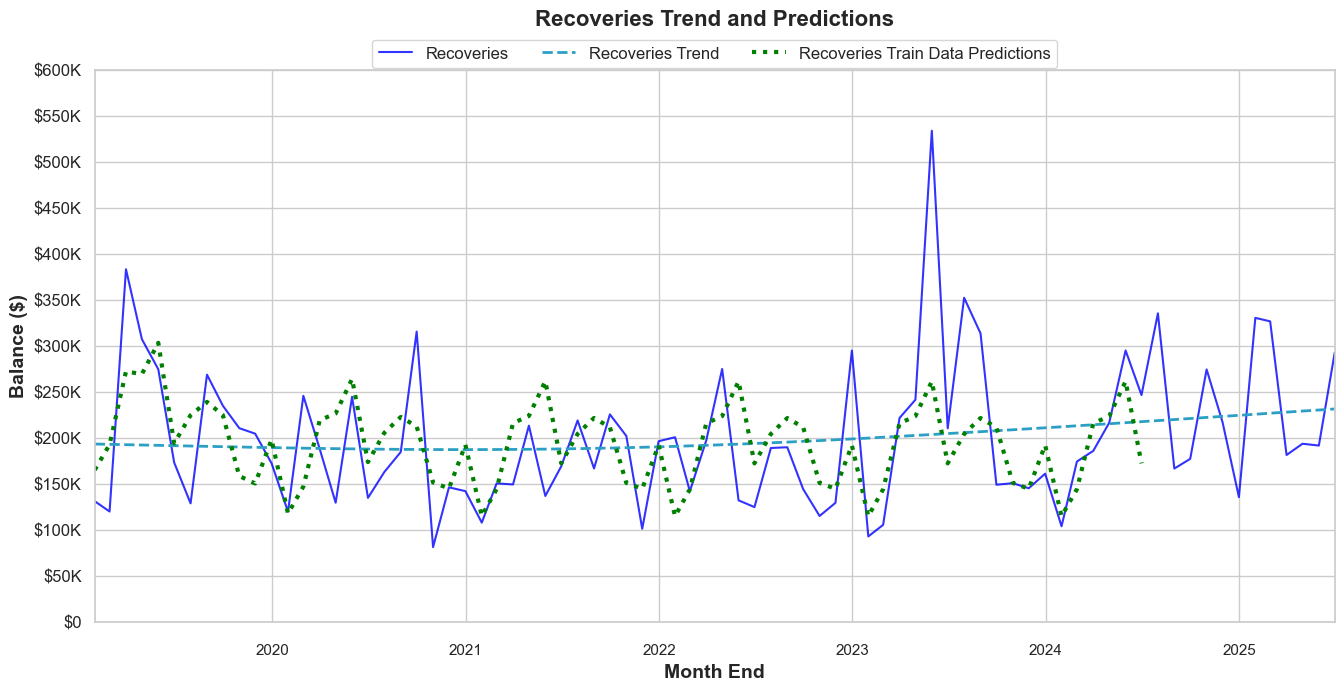

In [61]:
title = 'Recoveries Trend and Predictions'
plot_data(title, core_forecast_data, 'REC', 'Recoveries', 3,
              actual_data=True, trend_data=True, train_forecast=True, test_forecast=False, trend_train_forecast=False, trend_test_forecast=False, trend_ci=False)

In [62]:
average_train_data = rec_train_data.mean()
std_train_data = rec_train_data.std()

average_train_forecast_data = core_forecast_data[core_forecast_data.notna()]['REC_BAL_train_forecast'].mean()
std_train_forecast_data = core_forecast_data[core_forecast_data.notna()]['REC_BAL_train_forecast'].std()

print("Mean Training Data: ${:,.2f}".format(average_train_data))
print("Std Dev of Training Data: ${:,.2f}".format(std_train_data))
print("Mean Fitted Values: ${:,.2f}".format(average_train_forecast_data))
print("Std Dev Fitted Values: ${:,.2f}".format(std_train_forecast_data))

Mean Training Data: $193,618.71
Std Dev of Training Data: $78,696.98
Mean Fitted Values: $193,618.71
Std Dev Fitted Values: $44,549.60


Not perfect. But lets test it. 

#### 4.6a Test Recoveries Model

In [63]:
core_forecast_data = forecast_data(rec_train_fitted_model, core_forecast_data, rec_test_data, 'REC', trend=False)

Actual mean: $235,292
Stable forecast mean: $207,325
Ratio: 0.88x
MAPE: 64.09%
R²: -4.665


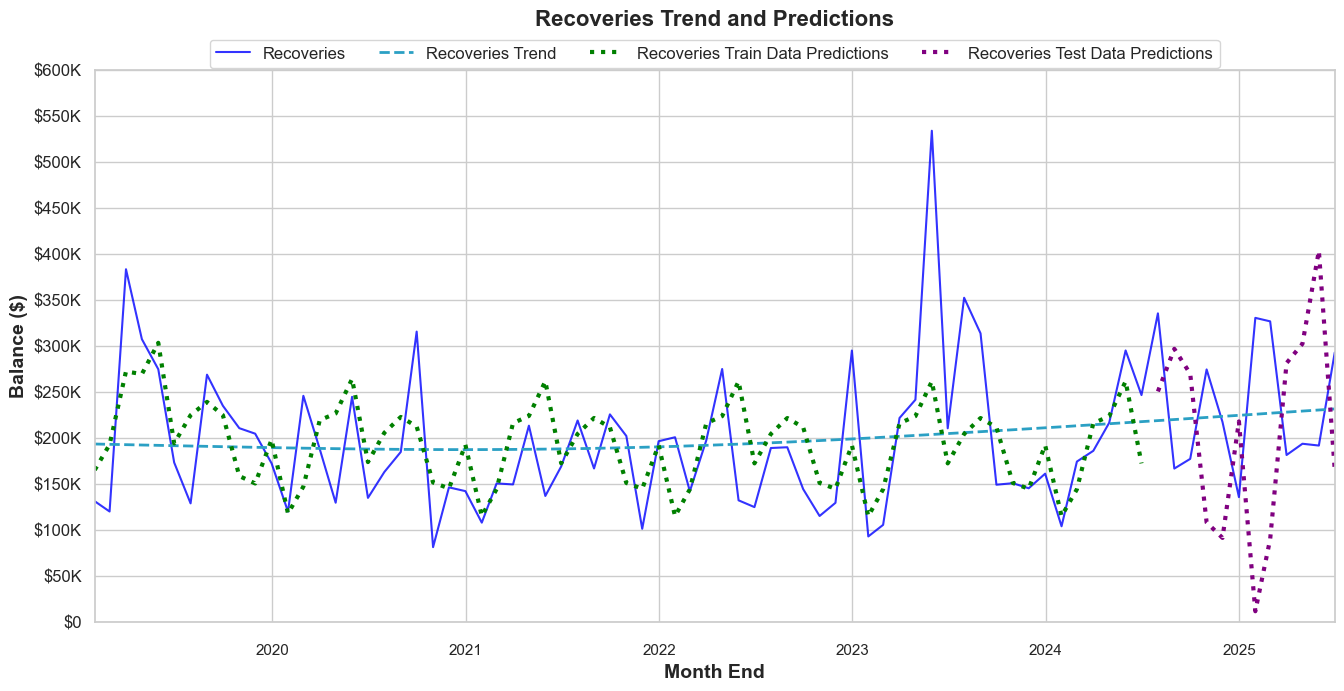

In [64]:
plot_data(title, core_forecast_data, 'REC', 'Recoveries', 4,
              actual_data=True, trend_data=True, train_forecast=True, test_forecast=True, trend_train_forecast=False, trend_test_forecast=False, trend_ci=False)

Data is stationary. Holtwinters is insufficient to capture the forecast appropriately. Lets try an Arima model.

In [65]:
# Use your recovery training data
recovery_train = rec_train_data  # Your 66-month training set
recovery_test = rec_test_data   # Your 12-month test set

# Test different p,q combinations (d=0 for stationary data)
arima_configs = [(0,0,1), (1,0,0), (1,0,1), (2,0,1), (1,0,2), (2,0,2)]
results = []

for p, d, q in arima_configs:
    try:
        model = ARIMA(recovery_train, order=(p, d, q))
        fitted_model = model.fit()
        
        # Generate forecast
        forecast = fitted_model.forecast(steps=len(recovery_test))
        
        # Calculate performance
        mape = np.mean(np.abs((recovery_test - forecast) / recovery_test)) * 100
        aic = fitted_model.aic
        
        results.append({
            'order': (p, d, q),
            'aic': aic,
            'mape': mape,
            'forecast': forecast,
            'model': fitted_model
        })
        
        print(f"ARIMA{(p,d,q)}: AIC={aic:.1f}, MAPE={mape:.2f}%")
        
    except Exception as e:
        print(f"ARIMA{(p,d,q)} failed: {e}")

# Find best model
best_model = min(results, key=lambda x: x['aic'])
print(f"\nBest ARIMA model: {best_model['order']}")
print(f"AIC: {best_model['aic']:.1f}, MAPE: {best_model['mape']:.2f}%")

ARIMA(0, 0, 1): AIC=1678.8, MAPE=22.73%
ARIMA(1, 0, 0): AIC=1678.4, MAPE=22.74%
ARIMA(1, 0, 1): AIC=1680.6, MAPE=22.87%
ARIMA(2, 0, 1): AIC=1681.3, MAPE=22.61%
ARIMA(1, 0, 2): AIC=1682.5, MAPE=22.86%
ARIMA(2, 0, 2): AIC=1681.9, MAPE=23.37%

Best ARIMA model: (1, 0, 0)
AIC: 1678.4, MAPE: 22.74%


In [66]:
# Fit the best model
best_arima = ARIMA(recovery_train, order=best_model['order'])
best_fitted = best_arima.fit()

# Generate forecasts
arima_forecast = best_fitted.forecast(steps=len(recovery_test))
arima_fitted_values = best_fitted.fittedvalues

# Get prediction intervals
forecast_result = best_fitted.get_forecast(steps=len(recovery_test))
arima_ci = forecast_result.conf_int()

print(f"ARIMA forecast range: ${arima_forecast.min():,.0f} to ${arima_forecast.max():,.0f}")
print(f"Actual test range: ${recovery_test.min():,.0f} to ${recovery_test.max():,.0f}")

ARIMA forecast range: $193,619 to $202,672
Actual test range: $135,646 to $335,375


No need to plot the data. We can already see its operating in a very narrow band. Lets try a Sarimax.

In [67]:


# Test multiple SARIMA configurations
# Corrected SARIMA configurations - (p,d,q)(P,D,Q,s) where s=12
sarima_configs = [
    (1,0,0,1,0,1,12),  # SARIMA(1,0,0)(1,0,1,12)
    (1,0,1,1,0,1,12),  # SARIMA(1,0,1)(1,0,1,12)  
    (0,0,1,1,0,1,12),  # SARIMA(0,0,1)(1,0,1,12)
    (2,0,1,1,0,1,12),  # SARIMA(2,0,1)(1,0,1,12)
    (1,0,0,0,0,1,12),  # SARIMA(1,0,0)(0,0,1,12)
]

sarima_results = []

for p,d,q,P,D,Q,s in sarima_configs:
    try:
        # Fit SARIMA model
        model = SARIMAX(recovery_train, 
                       order=(p,d,q), 
                       seasonal_order=(P,D,Q,s))
        fitted_model = model.fit(disp=False)
        
        # Generate forecast
        forecast = fitted_model.forecast(steps=len(recovery_test))
        
        # Calculate metrics
        mape = np.mean(np.abs((recovery_test - forecast) / recovery_test)) * 100
        aic = fitted_model.aic
        
        sarima_results.append({
            'order': (p,d,q),
            'seasonal_order': (P,D,Q,s),
            'aic': aic,
            'mape': mape,
            'forecast': forecast,
            'model': fitted_model
        })
        
        print(f"SARIMA({p},{d},{q})({P},{D},{Q},{s}): AIC={aic:.1f}, MAPE={mape:.2f}%")
        print(f"  Forecast range: ${forecast.min():,.0f} to ${forecast.max():,.0f}")
        
    except Exception as e:
        print(f"SARIMA({p},{d},{q})({P},{D},{Q},{s}) failed: {str(e)[:50]}")

# Find best SARIMA model
if sarima_results:
    best_sarima = min(sarima_results, key=lambda x: x['aic'])
    print(f"\nBest SARIMA model: {best_sarima['order']}{best_sarima['seasonal_order']}")
    print(f"AIC: {best_sarima['aic']:.1f}, MAPE: {best_sarima['mape']:.2f}%")

SARIMA(1,0,0)(1,0,1,12): AIC=1710.4, MAPE=33.66%
  Forecast range: $99,850 to $245,614
SARIMA(1,0,1)(1,0,1,12): AIC=1689.5, MAPE=30.57%
  Forecast range: $172,400 to $239,252
SARIMA(0,0,1)(1,0,1,12): AIC=1766.5, MAPE=37.60%
  Forecast range: $75,957 to $237,813
SARIMA(2,0,1)(1,0,1,12): AIC=1690.2, MAPE=28.51%
  Forecast range: $171,055 to $226,488
SARIMA(1,0,0)(0,0,1,12): AIC=1709.4, MAPE=49.99%
  Forecast range: $71,735 to $245,862

Best SARIMA model: (1, 0, 1)(1, 0, 1, 12)
AIC: 1689.5, MAPE: 30.57%


In [68]:
# Use the best configuration
best_order = best_sarima['order']
best_seasonal = best_sarima['seasonal_order']

final_sarima = SARIMAX(recovery_train, 
                      order=best_order, 
                      seasonal_order=best_seasonal)
final_fitted = final_sarima.fit(disp=False)

# Generate forecasts with confidence intervals
sarima_forecast = final_fitted.forecast(steps=len(recovery_test))
forecast_result = final_fitted.get_forecast(steps=len(recovery_test))
sarima_ci = forecast_result.conf_int()

print(f"SARIMA forecast range: ${sarima_forecast.min():,.0f} to ${sarima_forecast.max():,.0f}")
print(f"Actual test range: ${recovery_test.min():,.0f} to ${recovery_test.max():,.0f}")

# Compare performance
sarima_mape = np.mean(np.abs((recovery_test - sarima_forecast) / recovery_test)) * 100
sarima_r2 = r2_score(recovery_test, sarima_forecast)

print(f"\nSARIMA Performance:")
print(f"MAPE: {sarima_mape:.2f}%")
print(f"R²: {sarima_r2:.3f}")

SARIMA forecast range: $172,400 to $239,252
Actual test range: $135,646 to $335,375

SARIMA Performance:
MAPE: 30.57%
R²: -0.586


In [69]:
# Apply HP filter to recovery training data
recovery_trend = rec_trend
recovery_cycle = rec_cycle

# Extend trend for forecast period (simple linear extrapolation)
trend_slope = (recovery_trend.iloc[-1] - recovery_trend.iloc[-12]) / 12
extended_trend = [recovery_trend.iloc[-1] + trend_slope * i for i in range(1, 13)]

# Use cyclical component standard deviation for bands
cycle_std = recovery_cycle.std()
forecast_upper = extended_trend + (1.96 * cycle_std)
forecast_lower = extended_trend - (1.96 * cycle_std)

In [70]:
core_forecast_data['REC_BAL_future_forecast'] = np.nan
core_forecast_data['REC_BAL_future_forecast_upper_bound'] = np.nan
core_forecast_data['REC_BAL_future_forecast_lower_bound'] = np.nan

In [71]:
core_forecast_data.iloc[-12:, core_forecast_data.columns.get_loc('REC_BAL_future_forecast')] = extended_trend
core_forecast_data.iloc[-12:, core_forecast_data.columns.get_loc('REC_BAL_future_forecast_upper_bound')] = forecast_upper
core_forecast_data.iloc[-12:, core_forecast_data.columns.get_loc('REC_BAL_future_forecast_lower_bound')] = forecast_lower

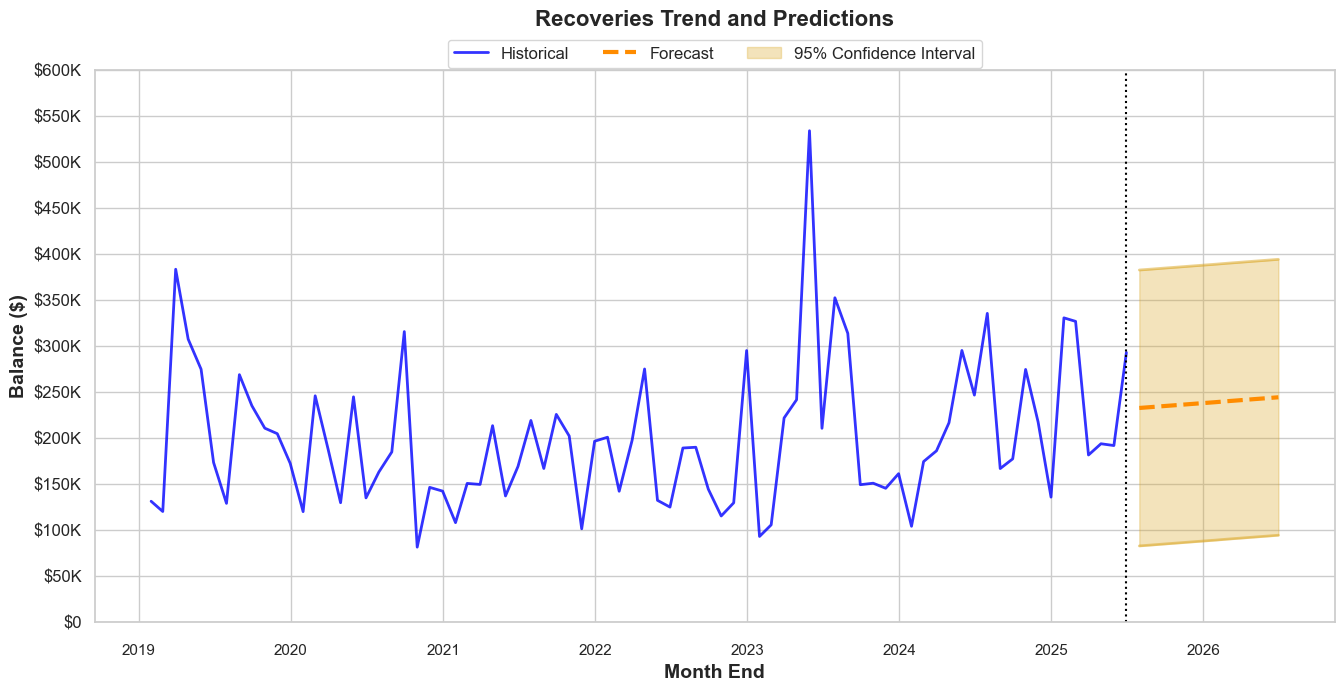

In [72]:
# Plot Charge-Off and ReRECvery Data Together
fig, ax = plt.subplots(figsize=(16,8))  # Changed this line

plt.title(title, size=16, fontweight='bold', pad=32)  # Add pad for spacing
# Historical data
ax.plot(core_forecast_data.index, core_forecast_data['REC_BAL'], color = 'blue', alpha = 0.8, label='Historical', linewidth=2)

# Future forecasts
ax.plot(core_forecast_data.index, core_forecast_data['REC_BAL_future_forecast'], color = "darkorange", linestyle='--', label='Forecast', linewidth=3)
ax.plot(core_forecast_data.index, core_forecast_data['REC_BAL_future_forecast_lower_bound'], alpha=0.5, color = "goldenrod", linewidth=2)
ax.plot(core_forecast_data.index, core_forecast_data['REC_BAL_future_forecast_upper_bound'], alpha=0.5, color = "goldenrod", linewidth=2)

ax.fill_between(future_dates, 
                np.array(forecast_lower), 
                np.array(forecast_upper), 
                alpha=0.3, color="goldenrod", label='95% Confidence Interval')

# Add vertical line at forecast start
ax.axvline(x=core_forecast_data['REC_BAL_future_forecast'].index[-13], color='black', linestyle=':')

#ax.autoscale(axis='x',tight=True)
ax.set_ylabel('Balance ($)', fontsize=14, fontweight='bold')
ax.set_xlabel('Month End', fontsize=14, fontweight='bold')

yticks = [0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000, 550000, 600000]
yticks_labels = ['$0', '$50K', '$100K', '$150K', '$200K', '$250K', '$300K', '$350K', '$400K', '$450K', '$500K', '$550K', '$600K']
ax.set_yticks(yticks, yticks_labels, fontsize=12)
ax.tick_params(axis='x', size=12)

# Position legend between title and plot
plt.legend(bbox_to_anchor=(0.5, 1.07), loc='upper center', ncol=4, fontsize=12)
plt.subplots_adjust(top=0.80)  # Make more room at the top
plt.ylim(0, max(yticks))
plt.show();

### COMMENT TO SELF: SCRAP TREND FORECASTING? NOT REALLY NECESSARY

#### 4.7a Forecasting on Full Dataset

## 5.0 Time Series Forecasting with XGBoost